# Tuning of parameters for DGA-Detector


In [1]:
"""
 * @file DGA-Detector-Parameter-Tuning.ipynb
 * @brief Tuning of parameters for the DGA (Domain Generation Algorithm) Detection models using a variety of machine learning techniques.
 *
 * This Jupyter notebook is dedicated to the optimization of several machine learning models for the purpose of detecting
 * malicious domain names generated by DGAs. It includes extensive data preprocessing, feature engineering, and the
 * application of various machine learning models including Logistic Regression, SVM, Decision Trees, Random Forests,
 * AdaBoost, XGBoost, LightGBM, and Neural Networks. Each model is tuned for optimal parameters using GridSearchCV and
 * evaluated on specific metrics such as F1 score, precision, recall, and AUC.
 *
 * The main functionalities of this notebook include:
 * - Loading and preprocessing data from Parquet files.
 * - Subsampling the dataset to balance classes and reduce computation time.
 * - Splitting the data into training and testing sets.
 * - Implementing and tuning multiple machine learning models to find the best parameters for each.
 * - Visualizing the performance of models over different parameters.
 * - Evaluating the performance of the tuned models on the test data.
 * - Providing detailed results and performance metrics to compare the efficacy of different approaches.
 *
 * This notebook serves as a comprehensive guide for training and optimizing DGA detection models, offering insights
 * into the use of different algorithms and their configurations to achieve the best possible performance in identifying
 * malicious domain activities.
 *
 * @version 1.0
 * @date 2024-03-22
 * @author Matej Keznikl (matej.keznikl@gmail.com)
 * @copyright Copyright (c) 2024
 *
"""

'\n * @file DGA-Detector-Parameter-Tuning.ipynb\n * @brief Tuning of parameters for the DGA (Domain Generation Algorithm) Detection models using a variety of machine learning techniques.\n *\n * This Jupyter notebook is dedicated to the optimization of several machine learning models for the purpose of detecting\n * malicious domain names generated by DGAs. It includes extensive data preprocessing, feature engineering, and the\n * application of various machine learning models including Logistic Regression, SVM, Decision Trees, Random Forests,\n * AdaBoost, XGBoost, LightGBM, and Neural Networks. Each model is tuned for optimal parameters using GridSearchCV and\n * evaluated on specific metrics such as F1 score, precision, recall, and AUC.\n *\n * The main functionalities of this notebook include:\n * - Loading and preprocessing data from Parquet files.\n * - Subsampling the dataset to balance classes and reduce computation time.\n * - Splitting the data into training and testing sets.

## Loading data


In [2]:
import pyarrow as pa
import pyarrow.parquet as pq

dga = pq.read_table("floor/02-Preprocessed-data/DGA/01-DGA-Features.parquet")
benign = pq.read_table(
    "floor/02-Preprocessed-data/Benign/00-Benign-Features.parquet")

# realign schemas (parquet files save in nonsense orders)
benign = benign.cast(dga.schema)

dga = dga.append_column("label", pa.array(["dga"] * len(dga)))
benign = benign.append_column("label", pa.array(["benign"] * len(benign)))

dga = dga.drop(["domain_name"])
benign = benign.drop(["domain_name"])

# concatentate tables
data = pa.concat_tables([dga, benign])
df = data.to_pandas()

# Handle NaNs
df.fillna(-1, inplace=True)

df

lex_name_len  lex_has_digit  lex_phishing_keyword_count  \
0                 15              0                           0   
1                 31              1                           0   
2                 19              0                           0   
3                 13              0                           1   
4                 30              1                           0   
...              ...            ...                         ...   
691813            15              0                           0   
691814            30              0                           0   
691815             9              0                           0   
691816             7              0                           0   
691817            10              0                           0   

        lex_consecutive_chars  lex_tld_len  lex_tld_abuse_score  lex_sld_len  \
0                           2            2               0.0000           12   
1                           2            3               0.0081           27   
2                           1            3               0.6554           15   
3                           1            4               0.0043            8   
4                           1            3               0.0081           26   
...                       ...          ...                  ...          ...   
691813                      2           10               0.0000            4   
691814                      2            5               0.0000            8   
691815                      2            2               0.0000            6   
691816                      3            3               0.0000            3   
691817                      3            6               0.0000            3   

        lex_sld_norm_entropy  lex_sld_digit_count  lex_sld_digit_ratio  ...  \
0                   0.237949                  0.0             0.000000  ...   
1                   0.151053                  9.0             0.333333  ...   
2                   0.221549                  0.0             0.000000  ...   
3                   0.375000                  0.0             0.000000  ...   
4                   0.165993                  8.0             0.307692  ...   
...                      ...                  ...                  ...  ...   
691813              0.375000                  0.0             0.000000  ...   
691814              0.343750                  0.0             0.000000  ...   
691815              0.375272                  0.0             0.000000  ...   
691816              0.000000                  0.0             0.000000  ...   
691817              0.000000                  0.0             0.000000  ...   

        mod_jaccard_tri-grams_benign  mod_jaccard_penta-grams_benign  \
0                           0.538462                        0.000000   
1                           0.172414                        0.000000   
2                           0.411765                        0.133333   
3                           0.454545                        0.222222   
4                           0.142857                        0.000000   
...                              ...                             ...   
691813                      0.615385                        0.454545   
691814                      0.714286                        0.307692   
691815                      0.571429                        0.000000   
691816                      0.400000                        0.000000   
691817                      0.625000                        0.833333   

        mod_jaccard_bi-grams_dga  mod_jaccard_tri-grams_dga  \
0                       0.857143                   0.076923   
1                       0.900000                   0.137931   
2                       0.888889                   0.529412   
3                       0.833333                   0.272727   
4                       0.689655                   0.107143   
...                          ...                  

## Subsampling the dataset


In [3]:
subsample = 1  # 1.0 means no subsample

if subsample < 1.0:
    df = df.sample(frac=subsample)

## Supressing unwanted warnings


In [4]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.*")
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost.*")
warnings.filterwarnings(
    "ignore", message="Series.__getitem__ treating keys as positions is deprecated.*"
)
warnings.filterwarnings("ignore", category=FutureWarning)

# Train-Test Split


In [5]:
from sklearn.model_selection import train_test_split

class_map = {"benign": 0, "dga": 1}

labels = df["label"].apply(lambda x: class_map[x])  # y vector
features = df.drop("label", axis=1).copy()  # X matrix

X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.3, random_state=42, shuffle=True, stratify=labels
)

## Display best performers


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


def visualize_performance(data):
    # Set the Seaborn theme
    sns.set(style="whitegrid")

    # Create a figure with high resolution
    plt.figure(figsize=(12, 12), dpi=300)
    ax = plt.axes()

    # Define the columns for training and testing scores
    training_col = "mean_train_score"
    testing_col = "mean_test_score"

    # Plotting with Seaborn for better visual effects
    sns.lineplot(
        x=data.index,
        y=data[training_col],
        ax=ax,
        marker="o",
        color="blue",
        label=training_col,
    )
    sns.lineplot(
        x=data.index,
        y=data[testing_col],
        ax=ax,
        marker="x",
        color="orange",
        label=testing_col,
    )

    # Annotate maximum points using a helper function
    annotate_max_points(ax, data, training_col, "blue")
    annotate_max_points(ax, data, testing_col, "red")

    # Adjust legend and show the plot
    plt.legend()
    plt.show()


def annotate_max_points(ax, data, column_name, color):
    # Find the maximum point in the dataset for the column
    max_index = data[column_name].idxmax()
    max_value = data[column_name].max()

    # Annotate the maximum value on the plot
    ax.scatter(
        max_index, max_value, color=color, s=100, zorder=5
    )  # zorder to bring points to the front
    ax.annotate(
        f"{max_value:.3f} (ID={max_index})",
        xy=(max_index, max_value),
        xytext=(0, 15),
        textcoords="offset points",
        ha="center",
        va="bottom",
        color=color,
        arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color=color),
    )

# Logistic Regression


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  12 | elapsed:   19.5s remaining:   19.5s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   30.1s finished


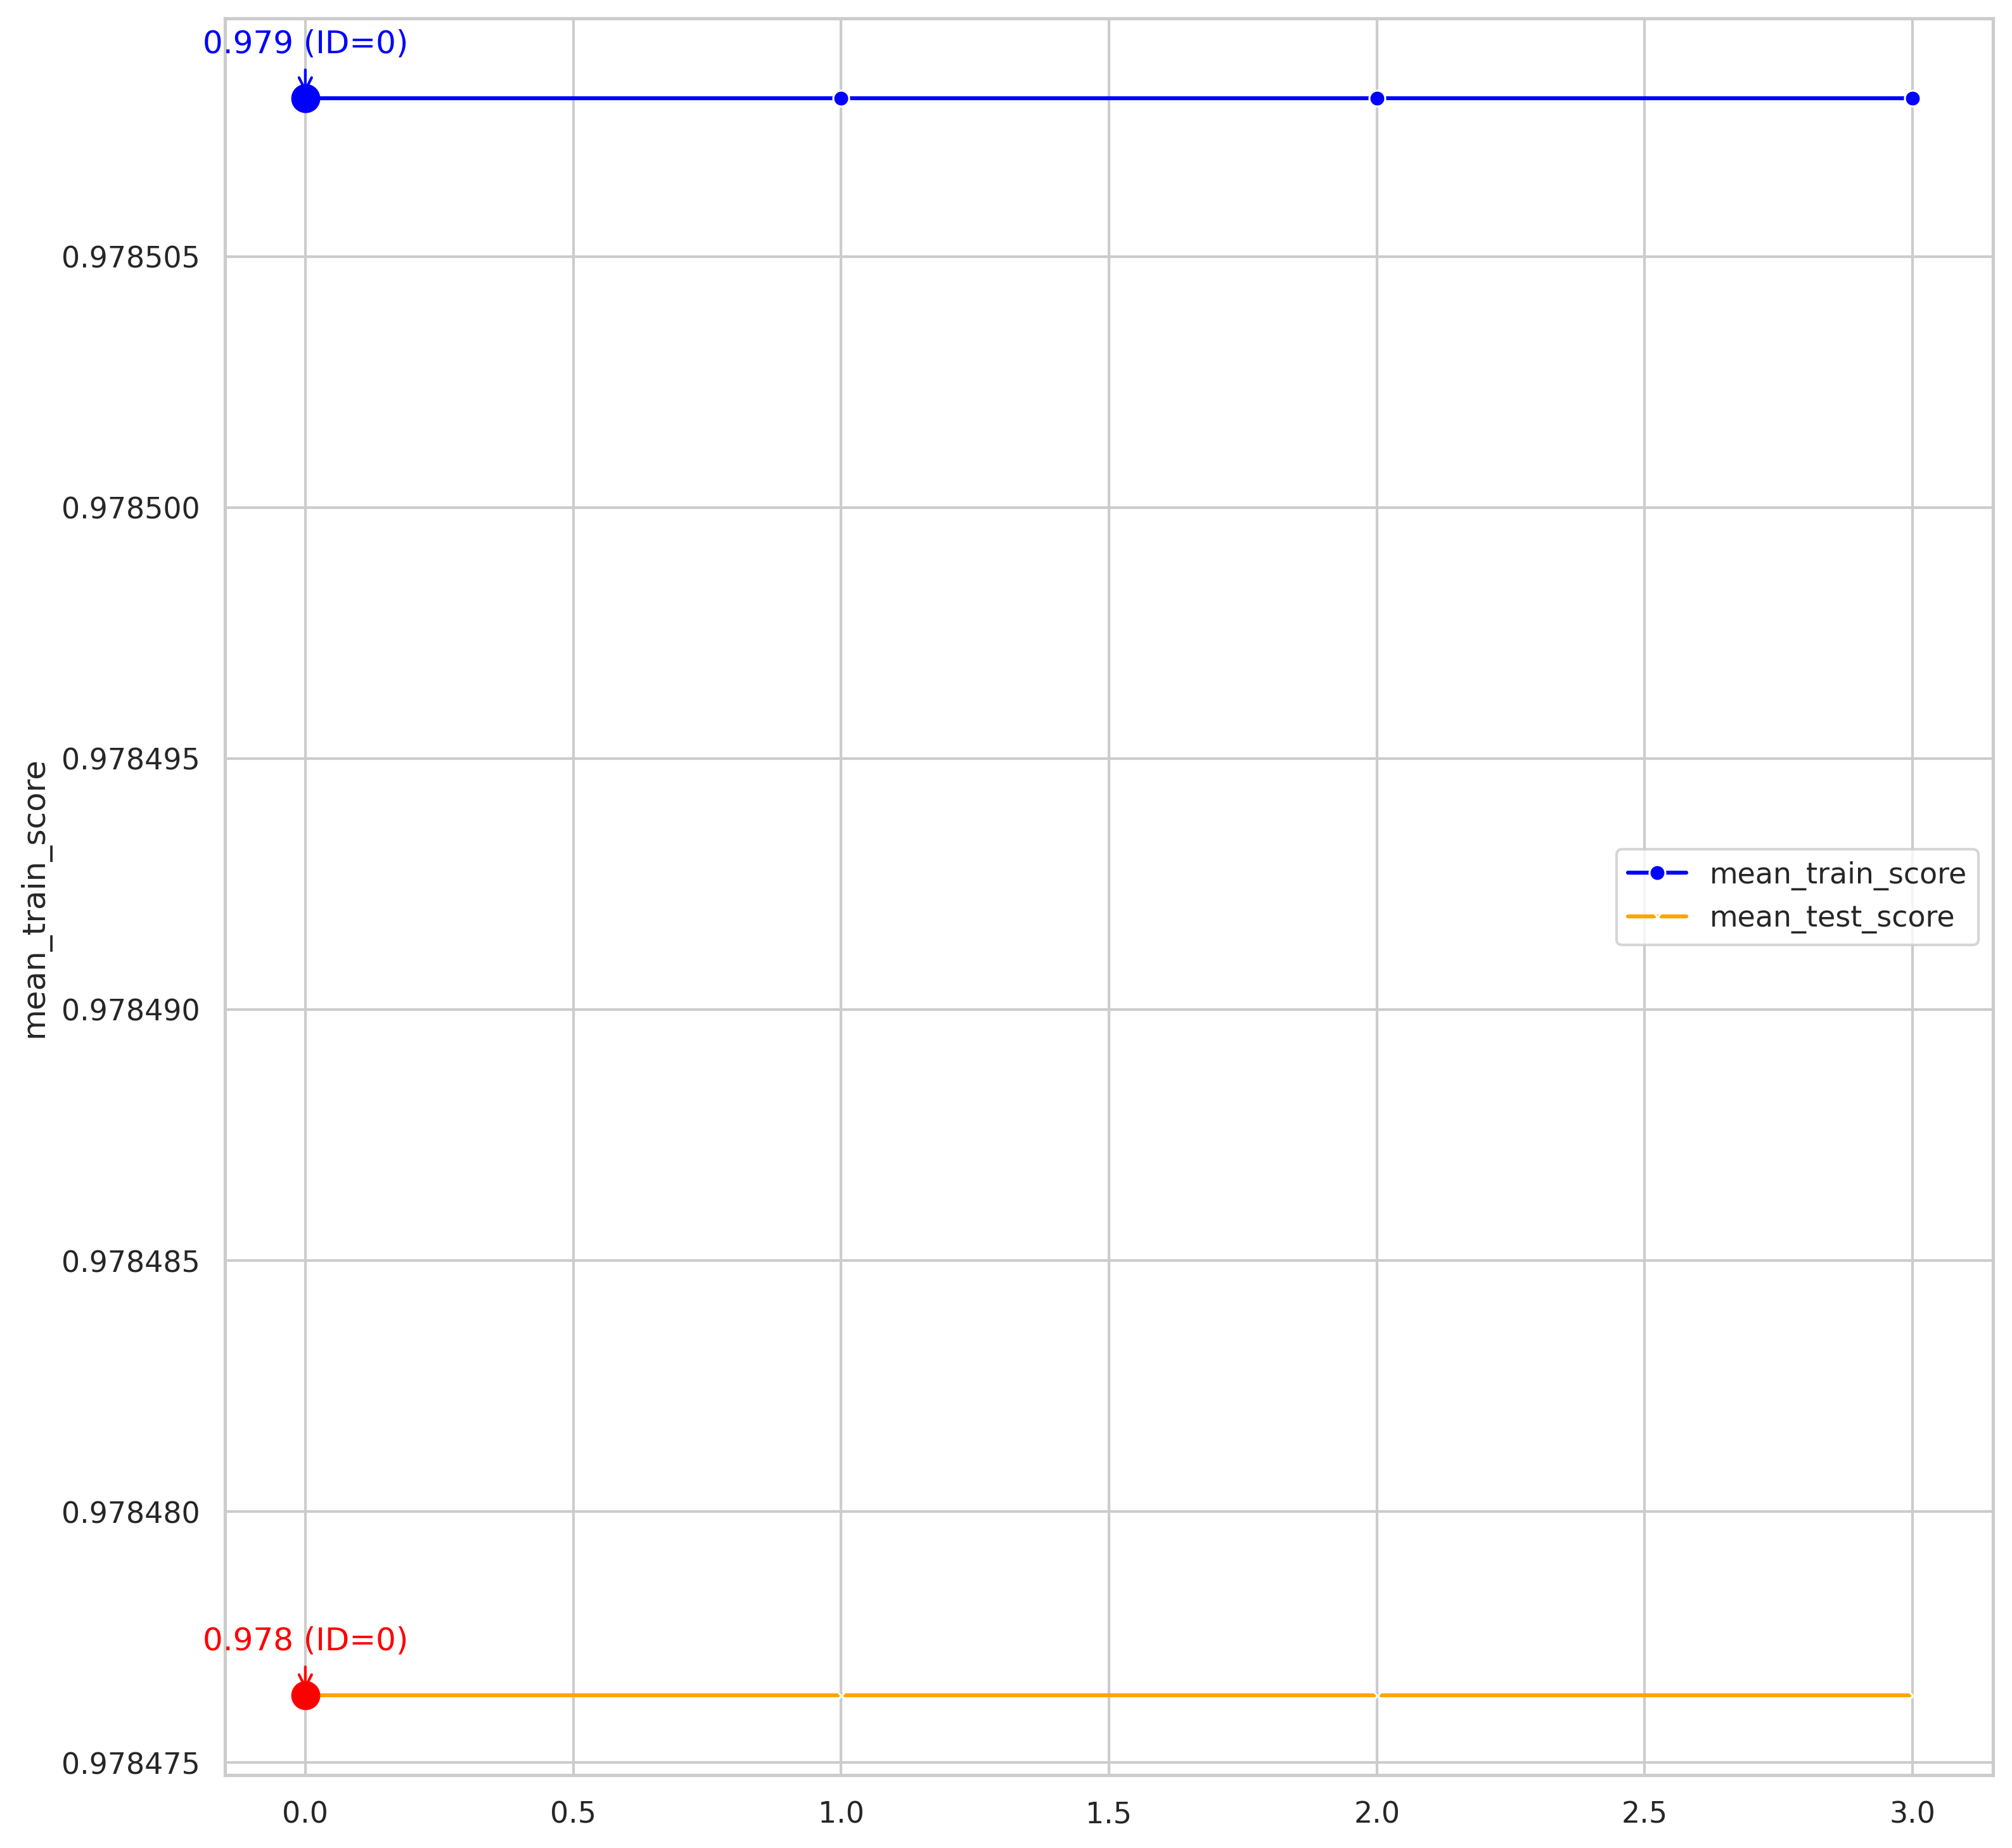

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0      18.926870      5.702687         0.020804        0.003814     100   
1      18.289750      6.074722         0.021112        0.004133     100   
2      18.847241      7.566124         0.018294        0.000486     100   
3      18.375768      7.887585         0.020435        0.001943     100   

  param_max_iter param_penalty param_solver  \
0            100            l2    liblinear   
1           1000            l2    liblinear   
2           3000            l2    liblinear   
3           5000            l2    liblinear   

                                              params  split0_test_score  \
0  {'C': 100, 'max_iter': 100, 'penalty': 'l2', '...           0.978556   
1  {'C': 100, 'max_iter': 1000, 'penalty': 'l2', ...           0.978556   
2  {'C': 100, 'max_iter': 3000, 'penalty': 'l2', ...           0.978556   
3  {'C': 100, 'max_iter': 5000, 'penalty': 'l2', ...           0.978556   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0           0.979665           0.977209         0.978476        0.001004   
1           0.979665           0.977209         0.978476        0.001004   
2           0.979665           0.977209         0.978476        0.001004   
3           0.979665           0.977209         0.978476        0.001004   

   rank_test_score  split0_train_score  split1_train_score  \
0                1            0.978372            0.977813   
1                1            0.978372            0.977813   
2                1            0.978372            0.977813   
3                1            0.978372            0.977813   

   split2_train_score  mean_train_score  std_train_score  
0             0.97934          0.978508         0.000631  
1             0.97934          0.978508         0.000631  
2             0.97934          0.978508         0.000631  
3             0.97934          0.978508         0.000631

In [6]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression model
log_reg_model = LogisticRegression(random_state=7)

# Grid of parameters to search
grid = {
    "C": [100],  # Regularization parameter (default: 1.0)
    "penalty": ["l2"],  # None, l1, l2 (default), elasticnet (both l1 and l2)
    # Maximum number of iterations (default: 100)
    "max_iter": [100, 1000, 3000, 5000],
    # lbfgs, liblinear, newton-cg, newton-cholesky, sag, saga}
    "solver": ["liblinear"],
}

# Stratified K-Fold cross-validator
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)

# Grid Search
grid_search = GridSearchCV(
    estimator=log_reg_model,
    param_grid=grid,
    cv=cv,
    scoring="f1",
    verbose=3,
    return_train_score=True,
    n_jobs=-1,  # Use all available CPUs
)

# Fit GridSearchCV to the scaled training data
grid_search.fit(X_train_scaled, y_train)

# Results of the grid search in a DataFrame
scores = pd.DataFrame(grid_search.cv_results_)

# Display tuning graph of grid search results
visualize_performance(scores)

# Set Pandas to display up to 50 columns of the DataFrame
pd.set_option("display.max_columns", 50)

# Print 5 best scores based on rank
scores.sort_values("rank_test_score").head()

# SVM


Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  36 | elapsed:  4.0min remaining:  4.0min
[Parallel(n_jobs=-1)]: Done  31 out of  36 | elapsed:  4.1min remaining:   40.1s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  5.4min finished


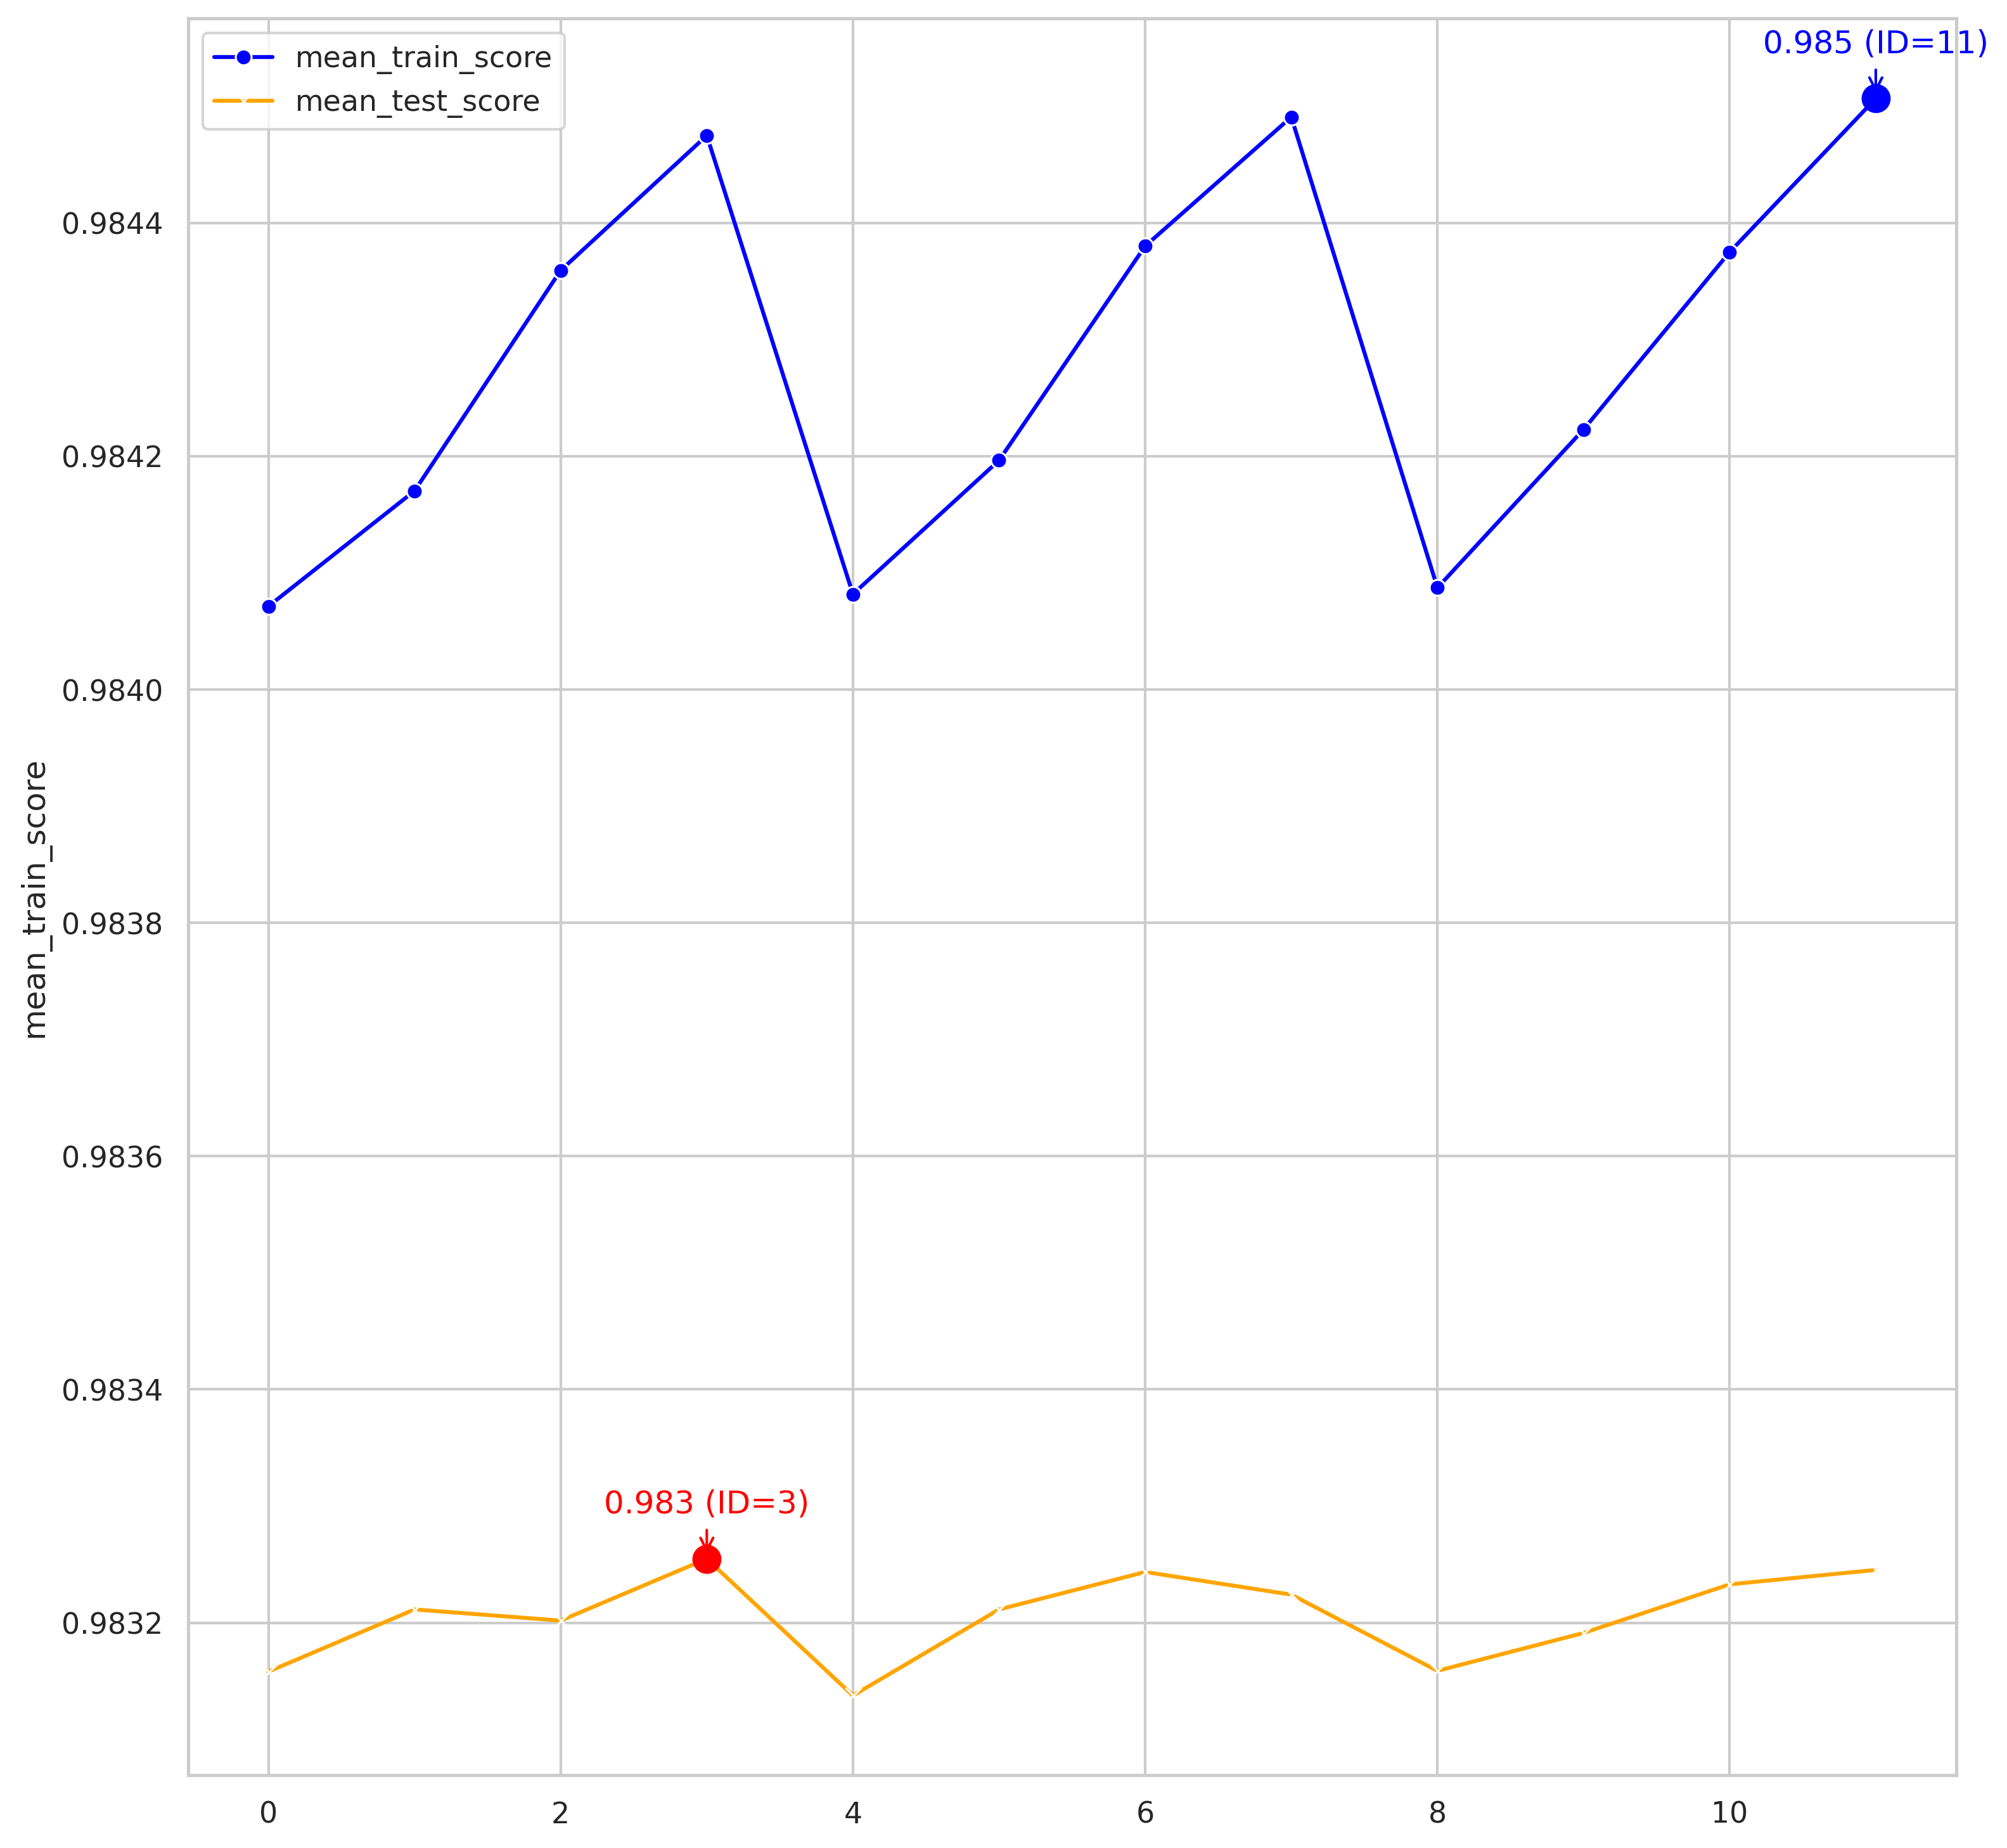

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
3       83.852639      0.931967        13.273646        0.174315      58   
11      56.409396      2.453686         8.064911        0.183287      60   
6       82.240580      2.528352        13.348358        0.753614      59   
10      72.382102     13.364725        12.352490        3.055830      60   
7       84.361718      2.689912        14.053867        0.162775      59   

   param_gamma param_kernel                                     params  \
3         0.12          rbf  {'C': 58, 'gamma': 0.12, 'kernel': 'rbf'}   
11        0.12          rbf  {'C': 60, 'gamma': 0.12, 'kernel': 'rbf'}   
6         0.11          rbf  {'C': 59, 'gamma': 0.11, 'kernel': 'rbf'}   
10        0.11          rbf  {'C': 60, 'gamma': 0.11, 'kernel': 'rbf'}   
7         0.12          rbf  {'C': 59, 'gamma': 0.12, 'kernel': 'rbf'}   

    split0_test_score  split1_test_score  split2_test_score  mean_test_score  \
3            0.983623           0.983915           0.982227         0.983255   
11           0.983624           0.983884           0.982228         0.983245   
6            0.983593           0.984036           0.982102         0.983243   
10           0.983593           0.984036           0.982070         0.983233   
7            0.983592           0.983884           0.982196         0.983224   

    std_test_score  rank_test_score  split0_train_score  split1_train_score  \
3         0.000737                1            0.984314            0.984242   
11        0.000727                2            0.984330            0.984289   
6         0.000827                3            0.984222            0.984160   
10        0.000842                4            0.984222            0.984145   
7         0.000737                5            0.984299            0.984273   

    split2_train_score  mean_train_score  std_train_score  
3             0.984869          0.984475         0.000280  
11            0.984901          0.984507         0.000279  
6             0.984758          0.984380         0.000268  
10            0.984758          0.984375         0.000273  
7             0.984901          0.984491         0.000290

In [7]:
import copy

import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

svm_x_train = copy.deepcopy(X_train)
svm_x_test = copy.deepcopy(X_test)

svm_y_train = copy.deepcopy(y_train)
svm_y_test = copy.deepcopy(y_test)

# Fill NaNs and scale features
svm_x_train = svm_x_train.fillna(0)
scaler = MinMaxScaler()
svm_x_train = scaler.fit_transform(svm_x_train)

# Support Vector Machine model
svm = SVC(random_state=7)

# Grid of parameters to search
grid = {
    "C": [58, 59, 60],  # Regularization parameter
    "gamma": [0.09, 0.1, 0.11, 0.12],  # Kernel coefficient
    "kernel": ["rbf"],  # ['rbf', 'linear', 'poly', 'sigmoid']
}

# Stratified K-Folds cross-validator
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)

# Grid Search
grid_search = GridSearchCV(
    estimator=svm,
    param_grid=grid,
    cv=cv,
    scoring="f1",
    verbose=3,
    return_train_score=True,
    n_jobs=-1,  # Use all available CPUs
)

# Fit GridSearchCV to the scaled training data
grid_search.fit(svm_x_train, svm_y_train)

# Results of the grid search in a DataFrame
scores = pd.DataFrame(grid_search.cv_results_)

# Display tuning graph of grid search results
visualize_performance(scores)

# Set Pandas to display up to 50 columns of the DataFrame
pd.set_option("display.max_columns", 50)

# Print 5 best scores based on rank
scores.sort_values("rank_test_score").head()

# Decision Tree


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   25.4s finished


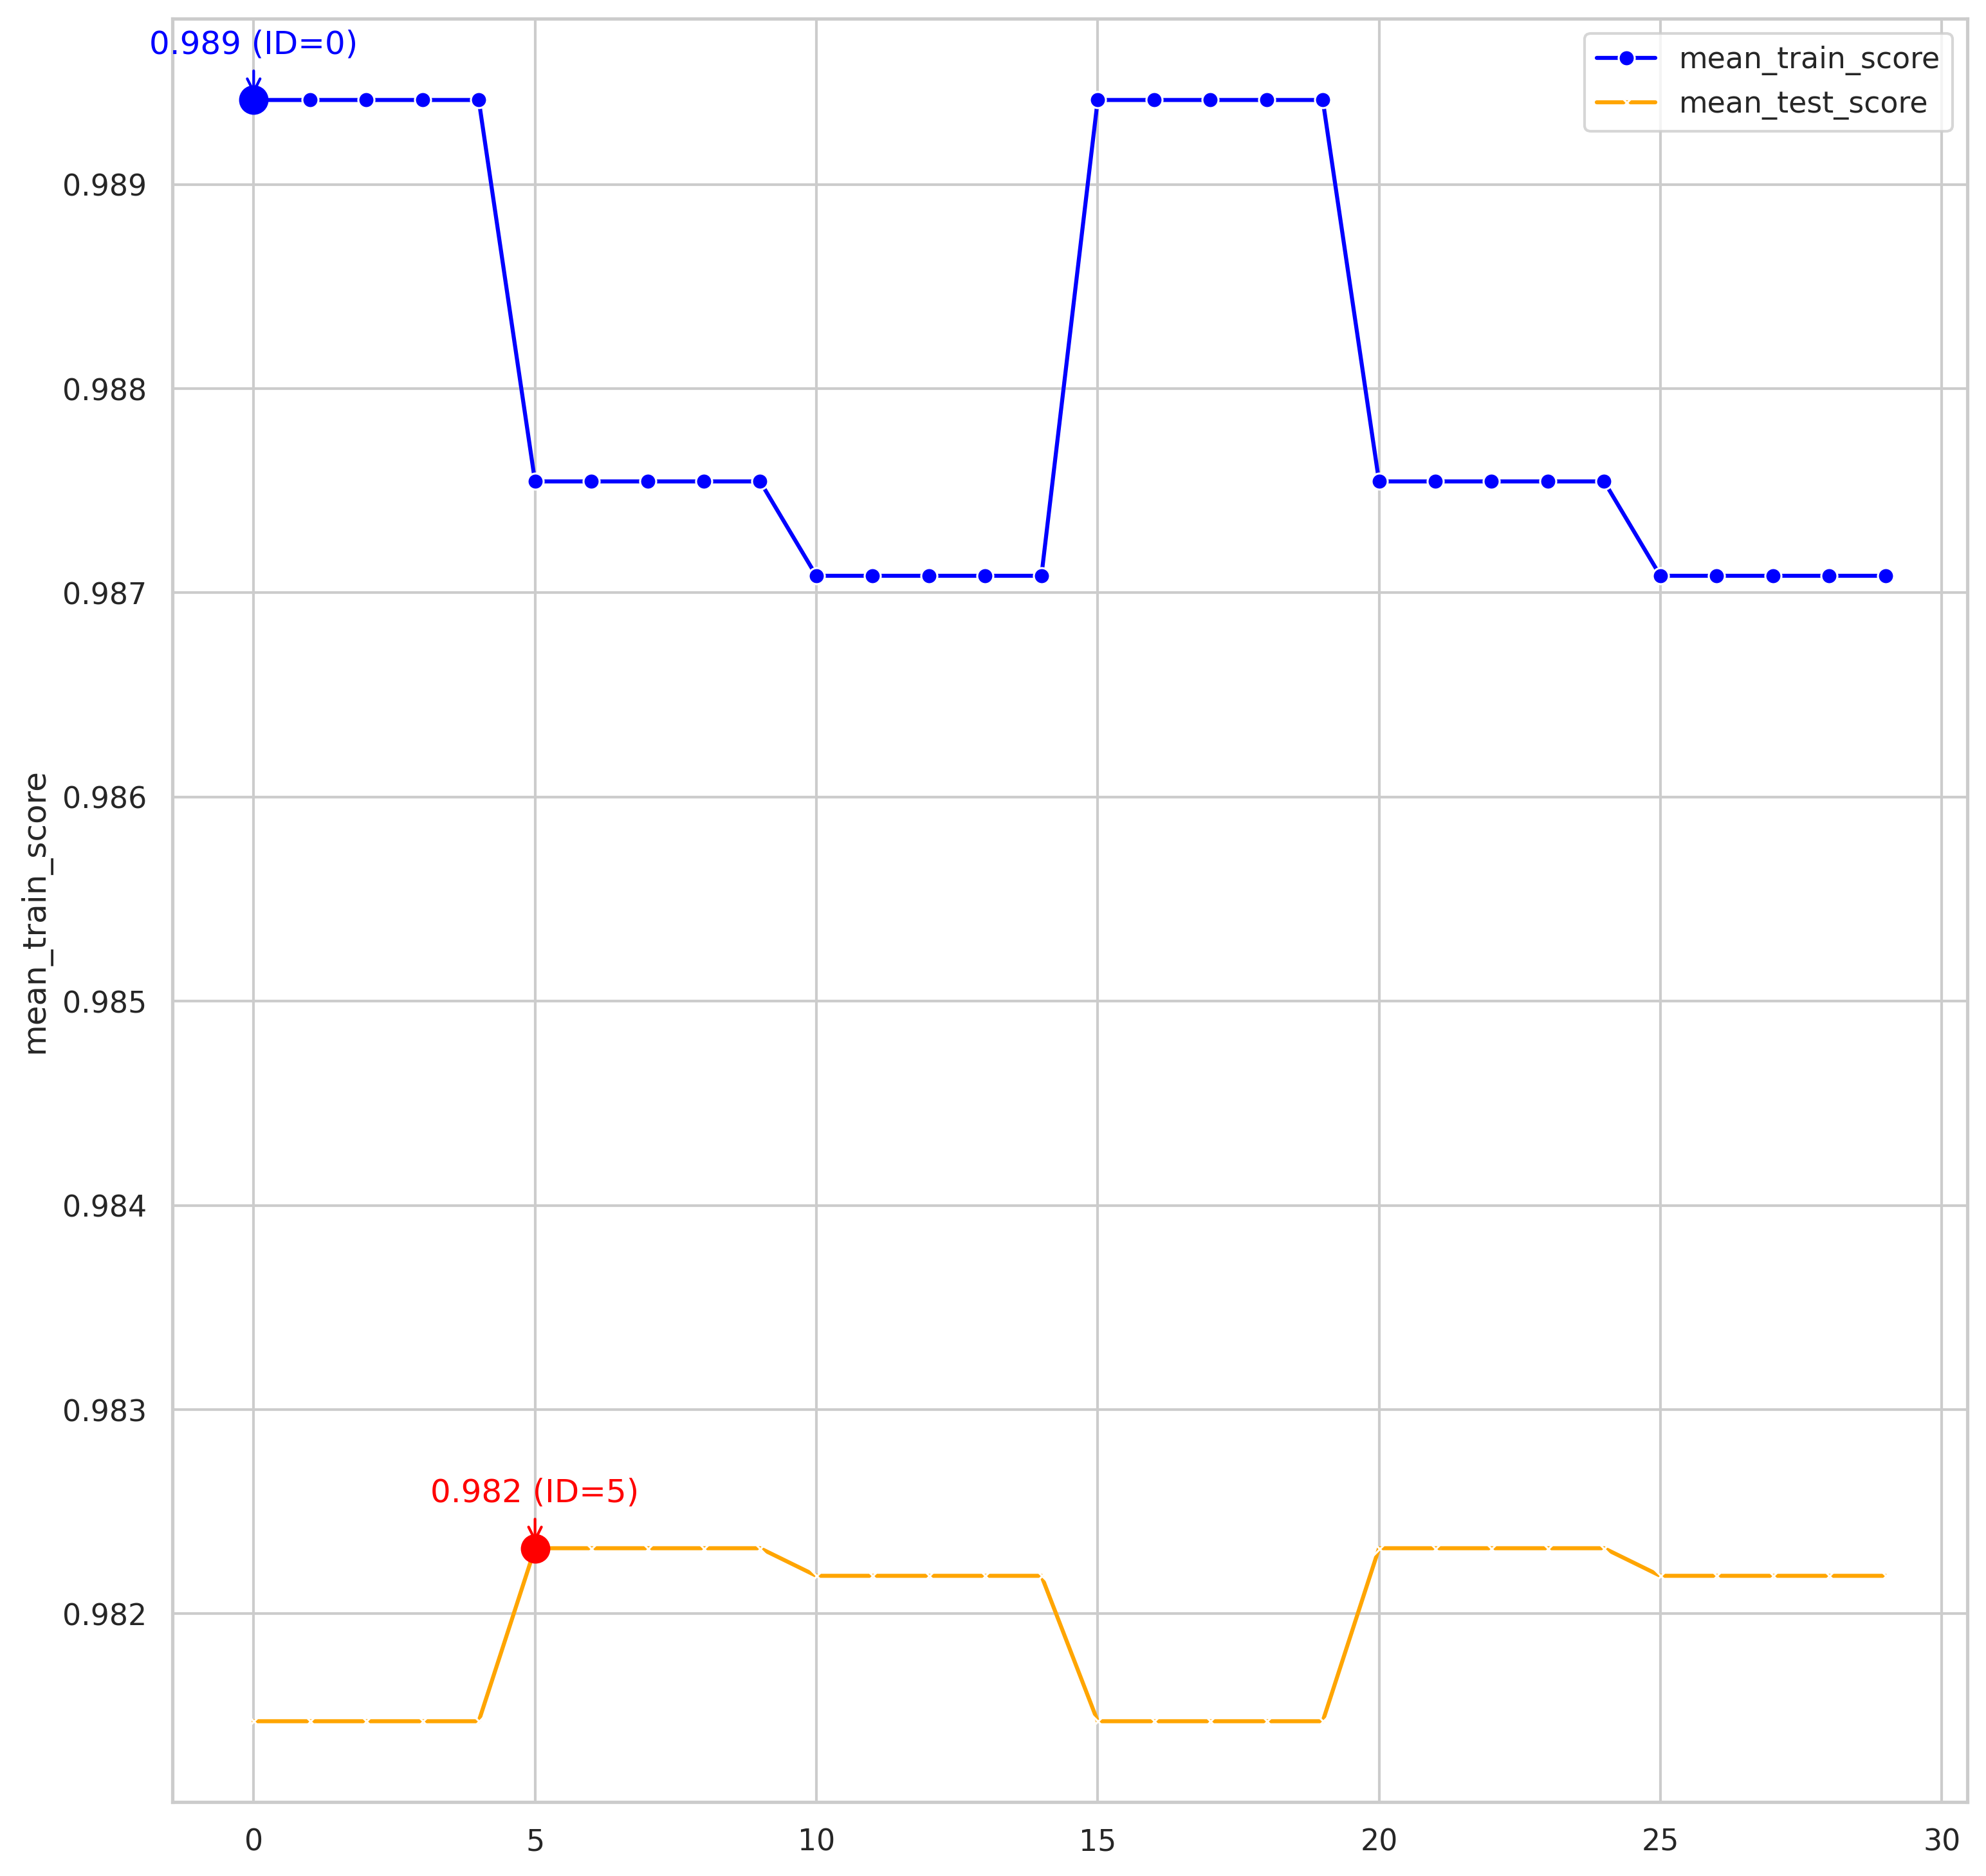

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
24       2.325432      0.072738         0.023619        0.001078   
5        2.335906      0.057574         0.024897        0.001939   
6        2.373939      0.074634         0.024210        0.001867   
7        2.356560      0.069102         0.023250        0.000407   
8        2.345328      0.070141         0.023459        0.000974   

   param_max_depth param_max_leaf_nodes param_min_samples_leaf  \
24              50                  500                      8   
5               30                  500                      8   
6               30                  500                      8   
7               30                  500                      8   
8               30                  500                      8   

   param_min_samples_split                                             params  \
24                       9  {'max_depth': 50, 'max_leaf_nodes': 500, 'min_...   
5                        5  {'max_depth': 30, 'max_leaf_nodes': 500, 'min_...   
6                        6  {'max_depth': 30, 'max_leaf_nodes': 500, 'min_...   
7                        7  {'max_depth': 30, 'max_leaf_nodes': 500, 'min_...   
8                        8  {'max_depth': 30, 'max_leaf_nodes': 500, 'min_...   

    split0_test_score  split1_test_score  split2_test_score  \
24           0.979976           0.983797           0.984657   
5            0.979976           0.983797           0.984657   
6            0.979976           0.983797           0.984657   
7            0.979976           0.983797           0.984657   
8            0.979976           0.983797           0.984657   

    split3_test_score  split4_test_score  mean_test_score  std_test_score  \
24           0.981635            0.98154         0.982321        0.001686   
5            0.981635            0.98154         0.982321        0.001686   
6            0.981635            0.98154         0.982321        0.001686   
7            0.981635            0.98154         0.982321        0.001686   
8            0.981635            0.98154         0.982321        0.001686   

    rank_test_score  split0_train_score  split1_train_score  \
24                1            0.987541            0.987332   
5                 1            0.987541            0.987332   
6                 1            0.987541            0.987332   
7                 1            0.987541            0.987332   
8                 1            0.987541            0.987332   

    split2_train_score  split3_train_score  split4_train_score  \
24            0.987422            0.987676            0.987754   
5             0.987422            0.987676            0.987754   
6             0.987422            0.987676            0.987754   
7             0.987422            0.987676            0.987754   
8             0.987422            0.987676            0.987754   

    mean_train_score  std_train_score  
24          0.987545         0.000156  
5           0.987545         0.000156  
6           0.987545         0.000156  
7           0.987545         0.000156  
8           0.987545         0.000156

In [9]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier

# Decision Tree base model
dt = DecisionTreeClassifier(random_state=7)

# Grid of parameters to search
grid = {
    "max_depth": [30, 50],  # Maximum depths or None for no limit
    "min_samples_split": range(
        5, 10
    ),  # Broader range for minimum number of samples required to split an internal node
    "min_samples_leaf": [
        5,
        8,
        9,
    ],  # Range for minimum number of samples required at a leaf node
    # Maximum number of leaf nodes or None for no limit
    "max_leaf_nodes": [500],
}

# Stratified K-Folds cross-validator
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

# Grid Search
grid_search = GridSearchCV(
    estimator=dt,
    param_grid=grid,
    cv=cv,
    scoring="f1",
    verbose=3,
    return_train_score=True,
    n_jobs=-1,  # Use all available CPUs
)

# Fit GridSearchCV to the scaled training data
grid_search.fit(X_train, y_train)

# Results of the grid search in a DataFrame
scores = pd.DataFrame(grid_search.cv_results_)

# Display tuning graph of grid search results
visualize_performance(scores)

# Set Pandas to display up to 50 columns of the DataFrame
pd.set_option("display.max_columns", 50)

# Print 5 best scores based on rank
scores.sort_values("rank_test_score").head()

# Random Forest


Fitting 3 folds for each of 2880 candidates, totalling 8640 fits
[CV] max_depth=30, max_leaf_nodes=500, min_samples_leaf=5, min_samples_split=6 
[CV]  max_depth=30, max_leaf_nodes=500, min_samples_leaf=5, min_samples_split=6, score=(train=0.990, test=0.980), total=   2.1s
[CV] max_depth=30, max_leaf_nodes=500, min_samples_leaf=5, min_samples_split=9 
[CV]  max_depth=30, max_leaf_nodes=500, min_samples_leaf=5, min_samples_split=9, score=(train=0.990, test=0.980), total=   2.1s
[CV] max_depth=30, max_leaf_nodes=500, min_samples_leaf=8, min_samples_split=7 
[CV]  max_depth=30, max_leaf_nodes=500, min_samples_leaf=8, min_samples_split=7, score=(train=0.988, test=0.980), total=   2.3s
[CV] max_depth=30, max_leaf_nodes=500, min_samples_leaf=8, min_samples_split=9 
[CV]  max_depth=30, max_leaf_nodes=500, min_samples_leaf=8, min_samples_split=9, score=(train=0.988, test=0.982), total=   2.5s
[CV] max_depth=30, max_leaf_nodes=500, min_samples_leaf=9, min_samples_split=8 
[CV]  max_depth=30, max

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed: 24.5min
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed: 35.2min
[Parallel(n_jobs=-1)]: Done 1536 tasks      | elapsed: 48.2min
[Parallel(n_jobs=-1)]: Done 2016 tasks      | elapsed: 63.4min
[Parallel(n_jobs=-1)]: Done 2560 tasks      | elapsed: 81.3min
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed: 100.2min
[Parallel(n_jobs=-1)]: Done 3840 tasks      | elapsed: 120.9min
[Parallel(n_jobs=-1)]: Done 4576 tasks      | elapsed: 144.0min
[Parallel(n_jobs=-1)]: Done 5376 tasks      | elapsed: 168.6min
[Parallel(n_jobs=-1)]: Done 6240 tasks      | elapsed: 195.2min
[Parallel(n_jobs=-1)]: Done 7168 tasks      | elapsed: 224.8min
[Parallel(n_jobs=-1)]: Done 8160 tasks 

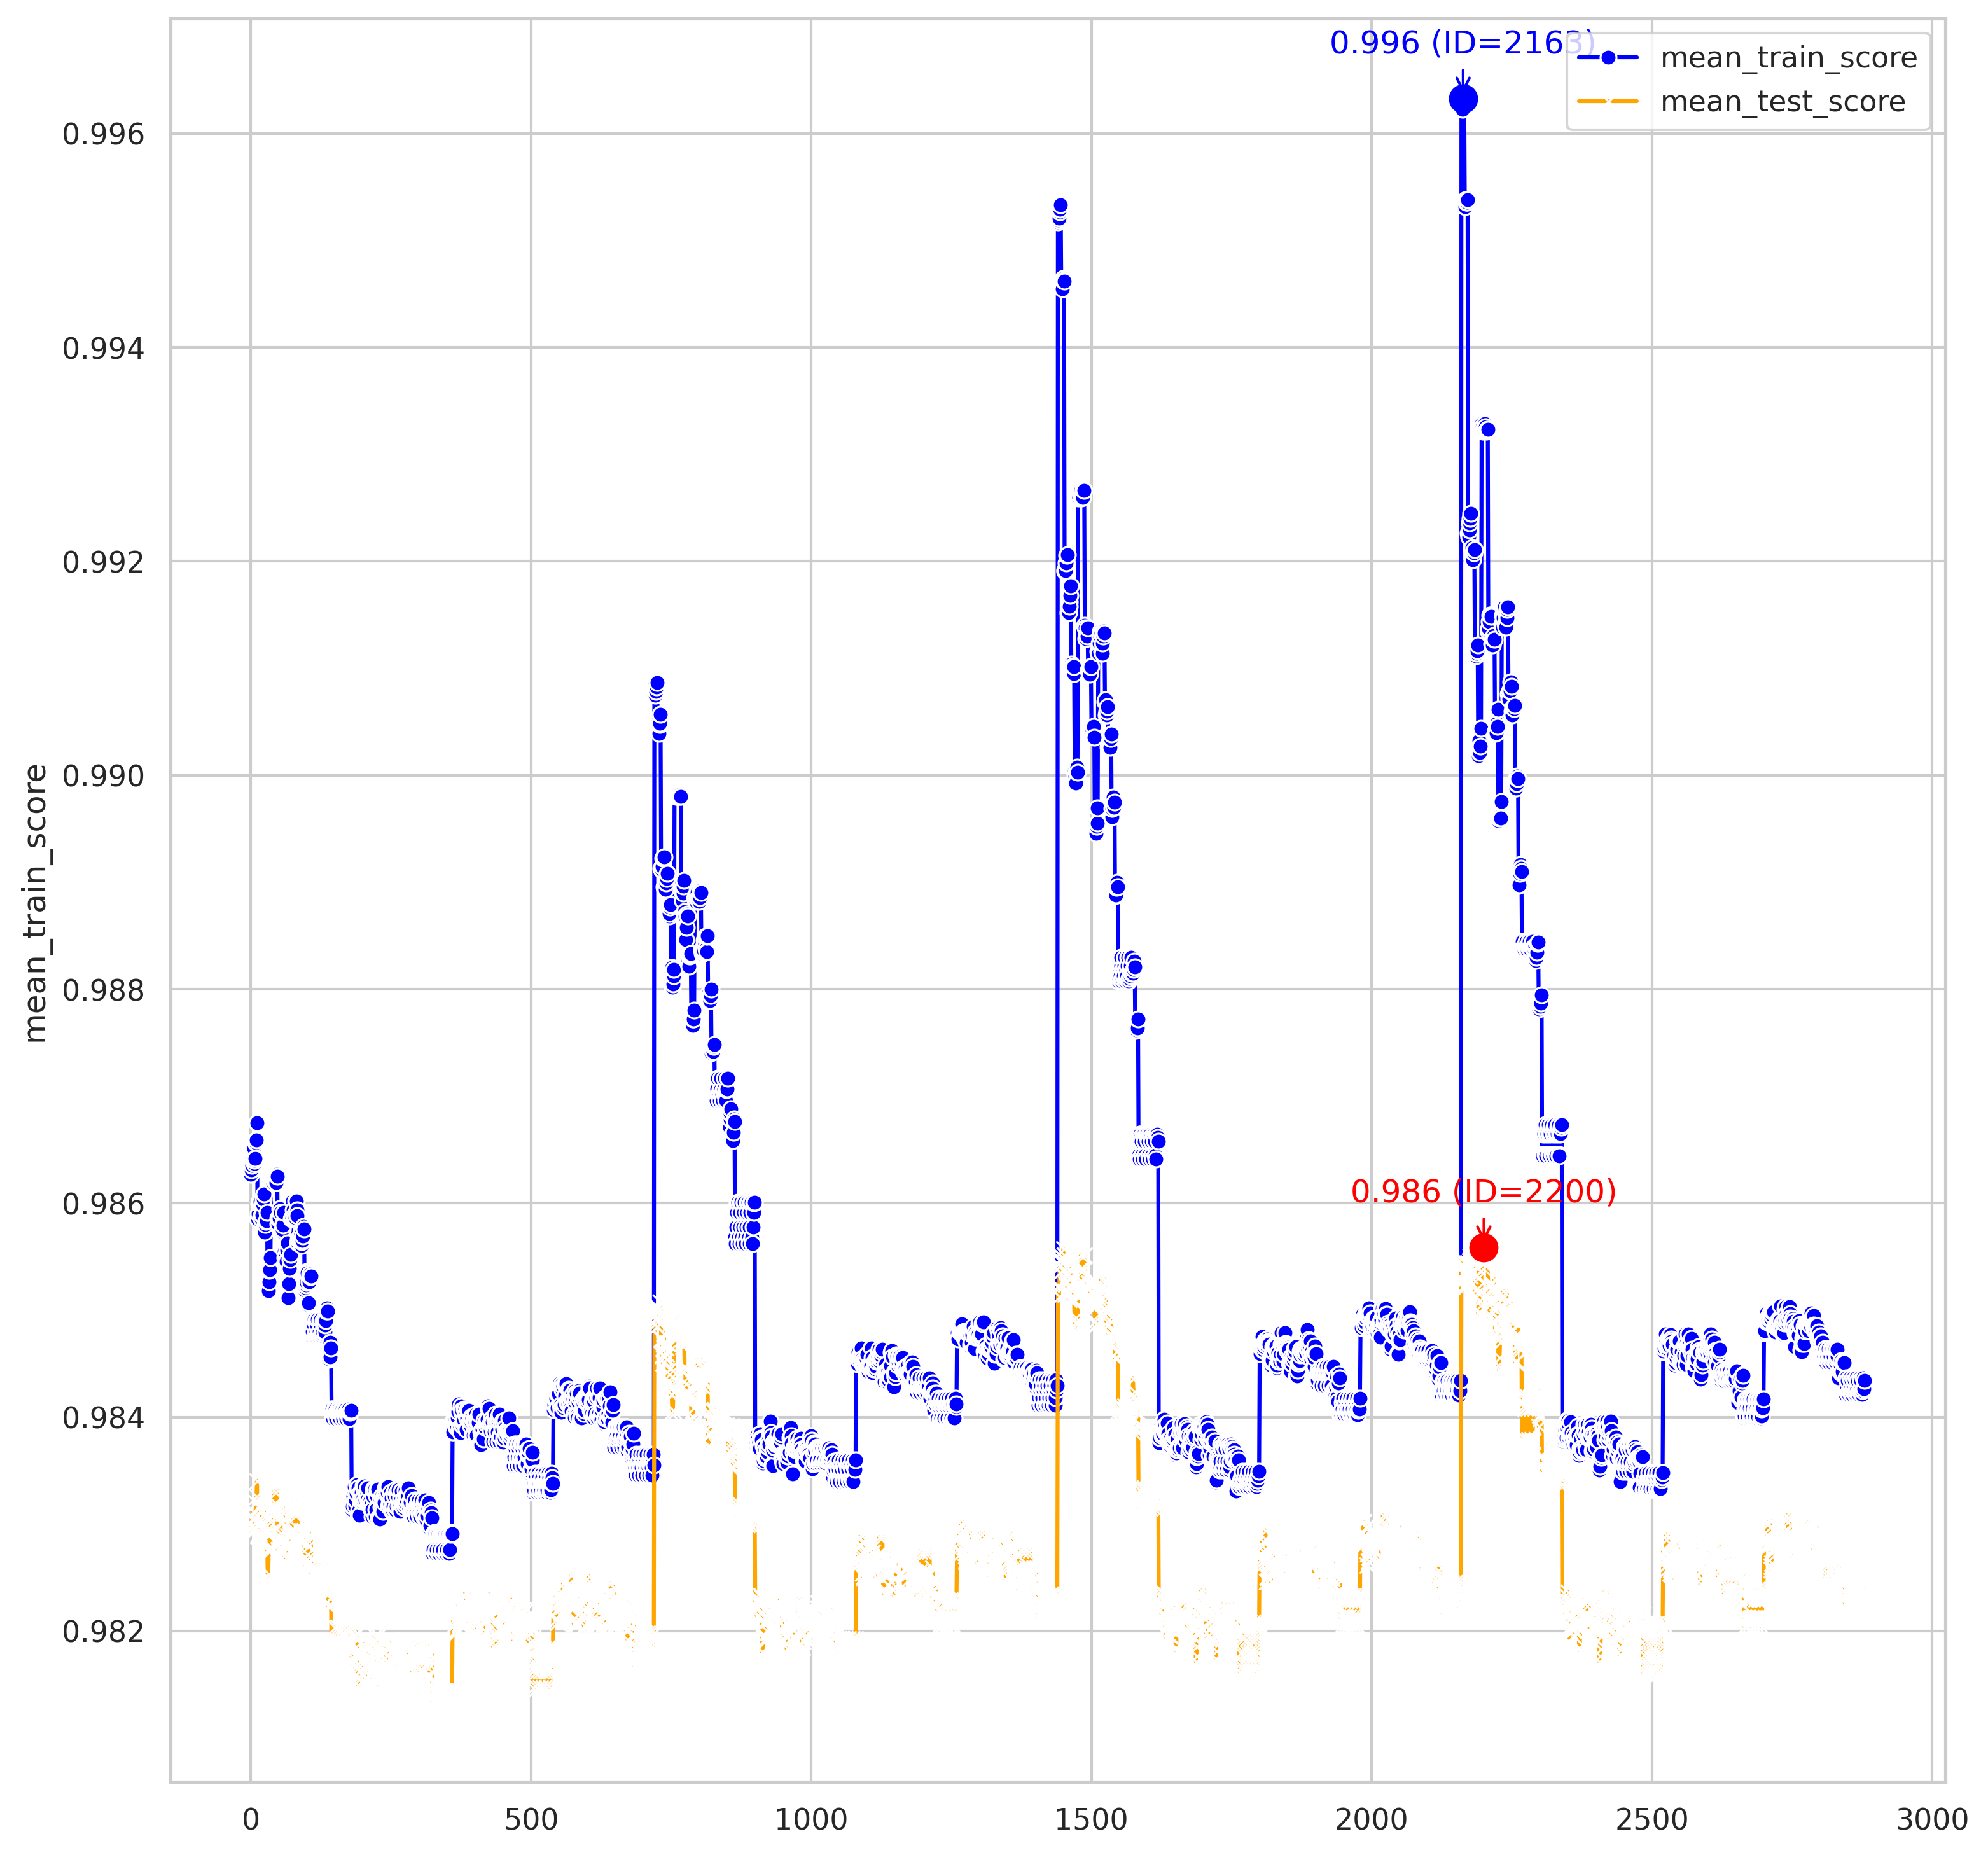

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
2200      32.037244      0.269265         2.086635        0.029171   
2206      32.292132      0.444929         1.966610        0.149242   
1450      31.386641      0.238969         2.186455        0.119535   
2199      27.961280      0.211826         2.462836        0.060238   
2205      27.815364      0.266439         2.389463        0.023233   

     param_class_weight param_criterion param_max_depth param_max_leaf_nodes  \
2200       {0: 1, 1: 5}         entropy              19                 None   
2206       {0: 1, 1: 5}         entropy              19                 None   
1450       {0: 1, 1: 5}         entropy              18                 None   
2199       {0: 1, 1: 5}         entropy              19                 None   
2205       {0: 1, 1: 5}         entropy              19                 None   

     param_min_samples_leaf param_min_samples_split param_n_estimators  \
2200                      2                       2                175   
2206                      2                       3                175   
1450                      1                       3                175   
2199                      2                       2                150   
2205                      2                       3                150   

                                                 params  split0_test_score  \
2200  {'class_weight': {0: 1, 1: 5}, 'criterion': 'e...           0.985225   
2206  {'class_weight': {0: 1, 1: 5}, 'criterion': 'e...           0.985225   
1450  {'class_weight': {0: 1, 1: 5}, 'criterion': 'e...           0.985293   
2199  {'class_weight': {0: 1, 1: 5}, 'criterion': 'e...           0.985257   
2205  {'class_weight': {0: 1, 1: 5}, 'criterion': 'e...           0.985257   

      split1_test_score  split2_test_score  mean_test_score  std_test_score  \
2200           0.986288           0.985236         0.985583        0.000498   
2206           0.986288           0.985236         0.985583        0.000498   
1450           0.986457           0.984971         0.985573        0.000639   
2199           0.986286           0.985175         0.985573        0.000506   
2205           0.986286           0.985175         0.985573        0.000506   

      rank_test_score  split0_train_score  split1_train_score  \
2200                1            0.992874            0.992800   
2206                1            0.992874            0.992800   
1450                3            0.994543            0.994175   
2199                4            0.992906            0.992800   
2205                4            0.992906            0.992800   

      split2_train_score  mean_train_score  std_train_score  
2200            0.994018          0.993231         0.000557  
2206            0.994018          0.993231         0.000557  
1450            0.995161          0.994627         0.000407  
2199            0.993955          0.993220         0.000521  
2205            0.993955          0.993220         0.000521

In [12]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Random Forest base model
rf = RandomForestClassifier(random_state=7, n_jobs=-1)

# Grid of parameters to search
grid = {
    # The function to measure the quality of a split. "entropy" is used for the information gain.
    "criterion": ["entropy"],
    # Weights associated with classes. In this case, class 0 has weight 1, and class 1 has weight 5.
    # This is used to address imbalances in the training data.
    "class_weight": [{0: 1, 1: 5}],
    # The number of trees in the forest. A list of possible values to try.
    "n_estimators": [99, 100, 125, 150, 175, 200],
    # The maximum depth of each tree. Deeper trees can learn more detailed data specifics, at the risk of overfitting.
    "max_depth": [11, 14, 18, 19],
    # The minimum number of samples required to split an internal node. Higher values prevent the model from learning overly specific patterns, thus reducing overfitting.
    "min_samples_split": [2, 3, 9, 10, 13, 17],
    # The minimum number of samples a node must have to be considered a leaf. Can help in controlling overfitting.
    "min_samples_leaf": [1, 2, 3, 6, 9],
    # The maximum number of leaf nodes per tree. 'None' means unlimited. Limiting this number can effectively reduce model complexity.
    "max_leaf_nodes": [None, 150, 180, 190],
}

# Stratified K-Folds cross-validator
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)

# Grid Search
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=grid,
    cv=cv,
    scoring="f1",
    verbose=3,
    return_train_score=True,
    n_jobs=-1,  # Use all available CPUs
)

# Fit GridSearchCV to the scaled training data
grid_search.fit(X_train, y_train)

# Results of the grid search in a DataFrame
scores = pd.DataFrame(grid_search.cv_results_)

# Display tuning graph of grid search results
visualize_performance(scores)

# Set Pandas to display up to 50 columns of the DataFrame
pd.set_option("display.max_columns", 50)

# Print 5 best scores based on rank
scores.sort_values("rank_test_score").head()

# AdaBoost


Fitting 3 folds for each of 18 candidates, totalling 54 fits

[CV] class_weight={0: 1, 1: 5}, criterion=entropy, max_depth=19, max_leaf_nodes=190, min_samples_leaf=2, min_samples_split=17, n_estimators=99 
[CV]  class_weight={0: 1, 1: 5}, criterion=entropy, max_depth=19, max_leaf_nodes=190, min_samples_leaf=2, min_samples_split=17, n_estimators=99, score=(train=0.985, test=0.982), total=  21.0s
[CV] class_weight={0: 1, 1: 5}, criterion=entropy, max_depth=19, max_leaf_nodes=190, min_samples_leaf=2, min_samples_split=17, n_estimators=150 
[CV]  class_weight={0: 1, 1: 5}, criterion=entropy, max_depth=19, max_leaf_nodes=190, min_samples_leaf=2, min_samples_split=17, n_estimators=150, score=(train=0.985, test=0.982), total=  27.6s
[CV] class_weight={0: 1, 1: 5}, criterion=entropy, max_depth=19, max_leaf_nodes=190, min_samples_leaf=3, min_samples_split=2, n_estimators=125 
[CV]  class_weight={0: 1, 1: 5}, criterion=entropy, max_depth=19, max_leaf_nodes=190, min_samples_leaf=3, min_samples_sp

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of  54 | elapsed:  3.6min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  4.6min finished


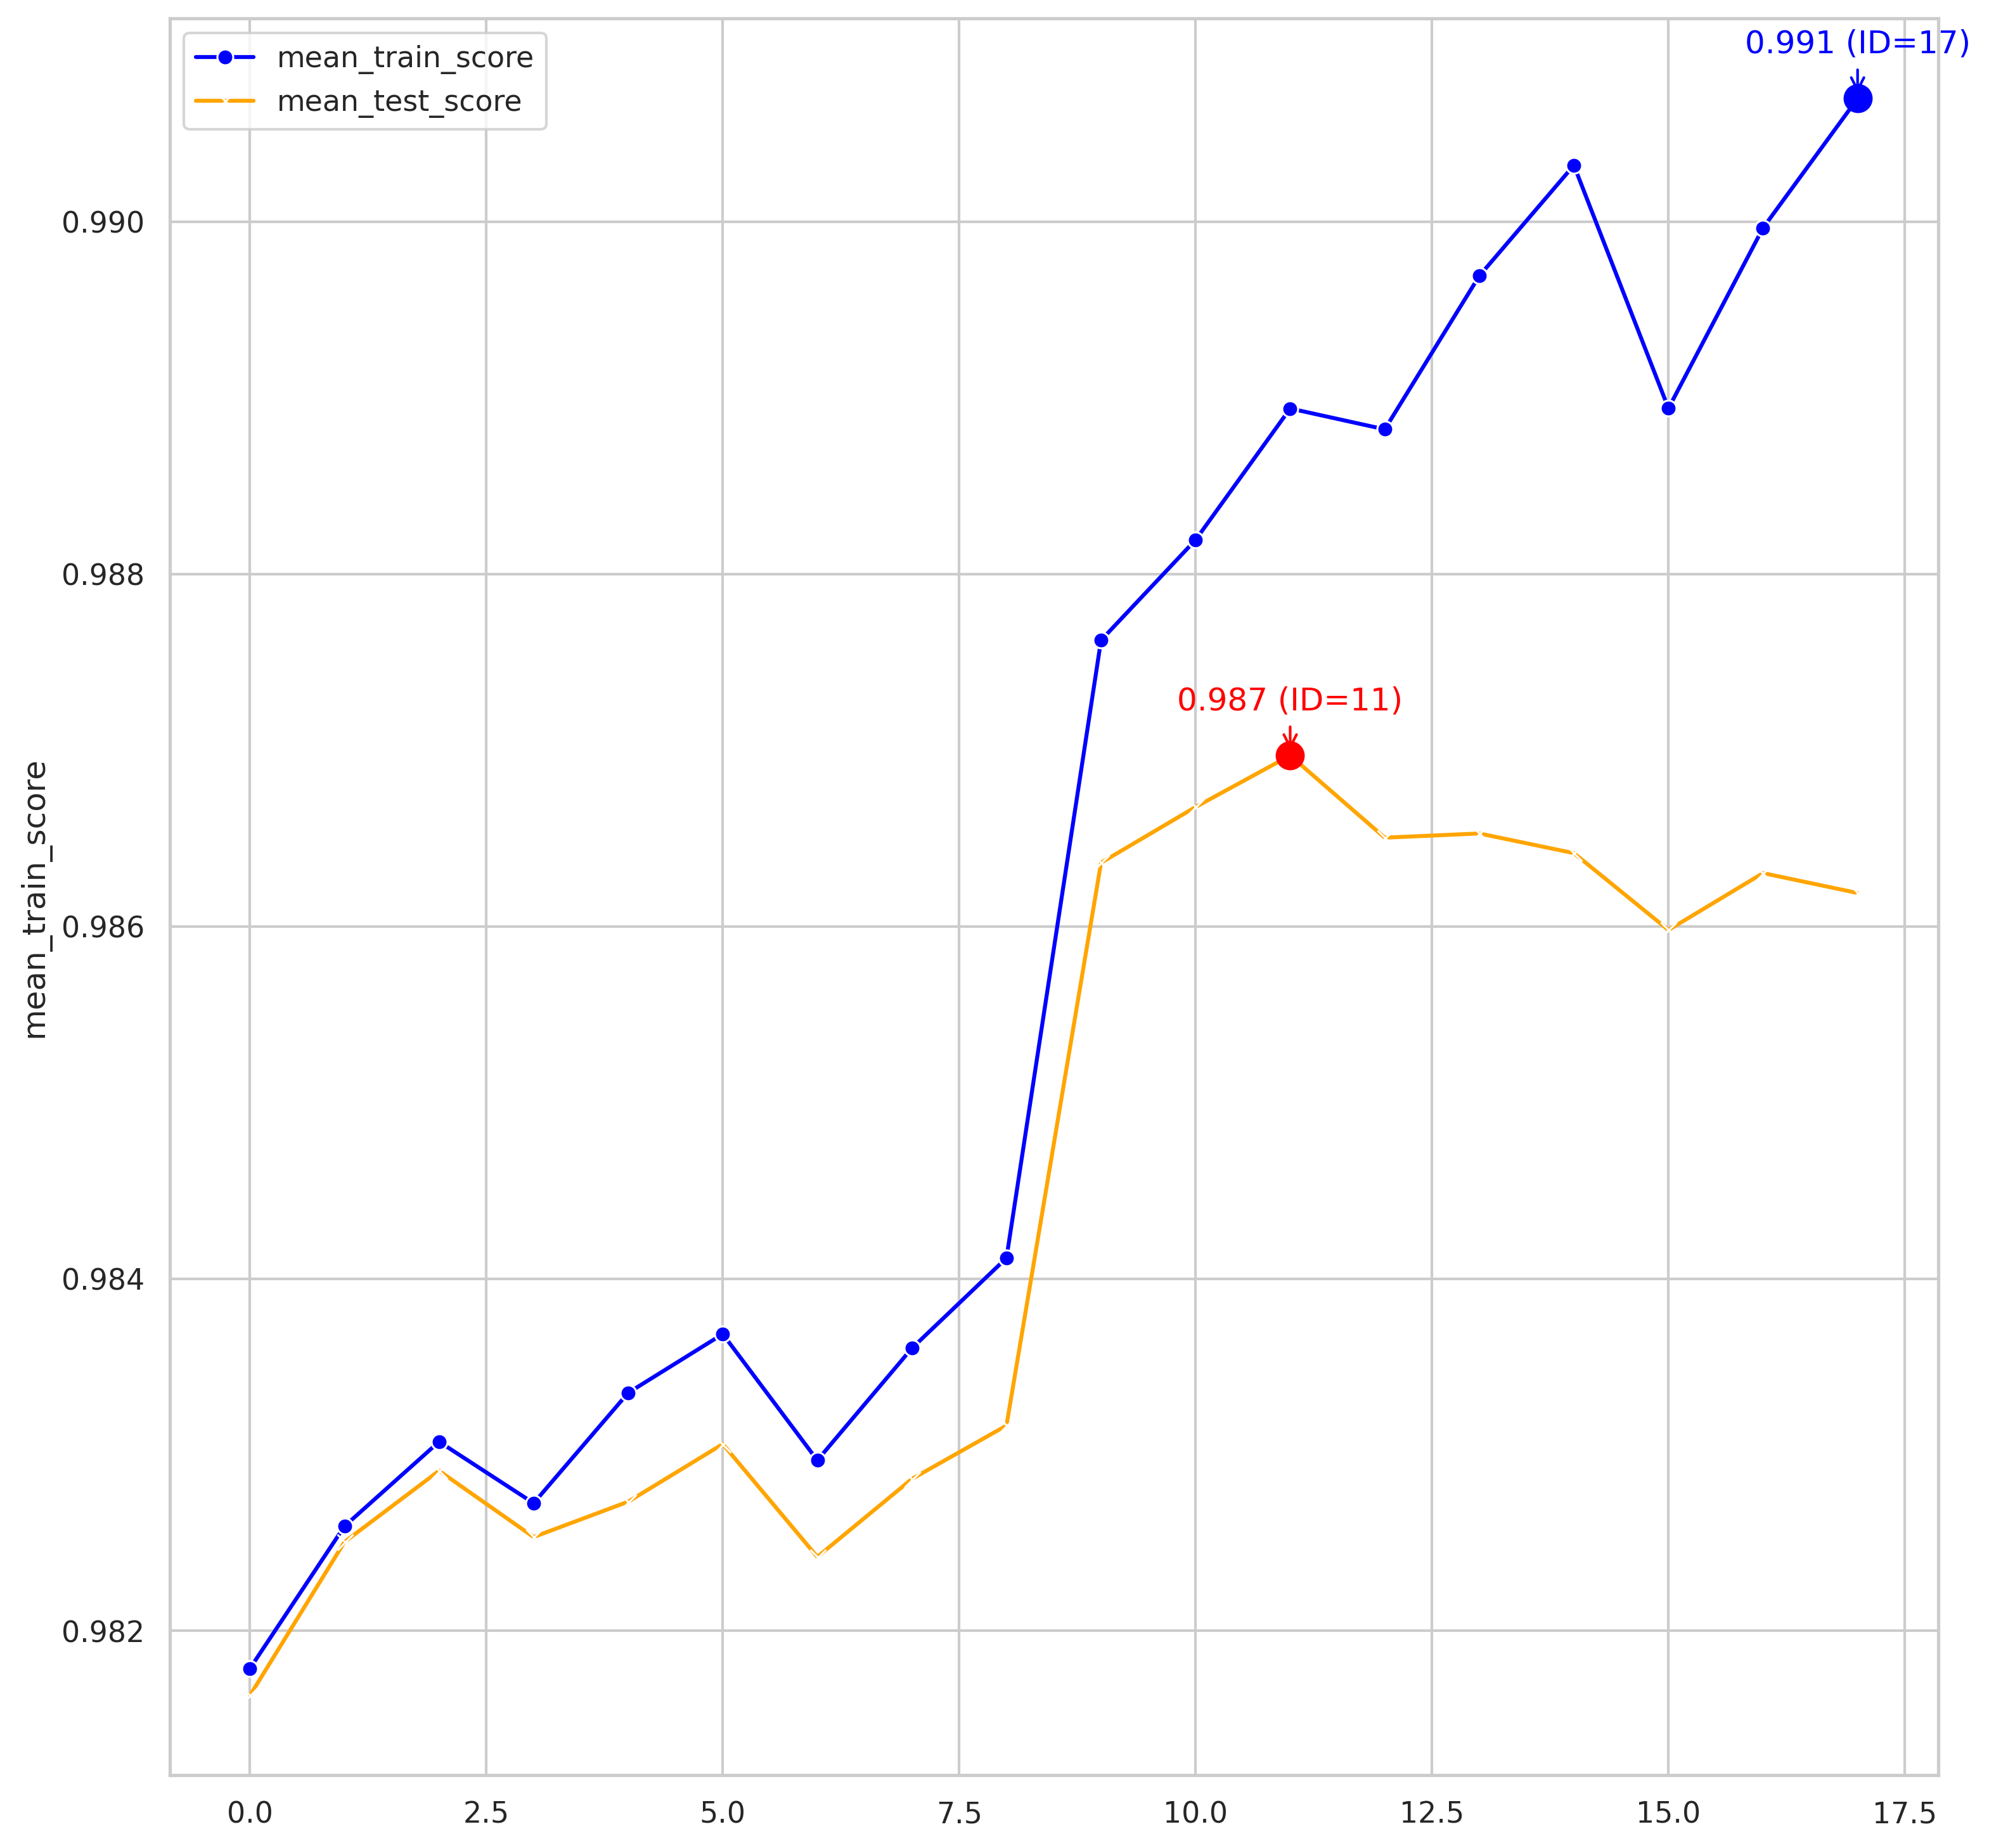

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
11     108.339255      1.863764         2.914466        0.027078   
10      86.667510      0.288200         2.501076        0.107791   
13      84.720360      0.966204         2.326380        0.016520   
12      62.045249      0.223319         1.791686        0.010305   
14     101.368337      2.739011         2.548463        0.386343   

                                 param_base_estimator param_learning_rate  \
11  DecisionTreeClassifier(ccp_alpha=0.0, class_we...                 0.4   
10  DecisionTreeClassifier(ccp_alpha=0.0, class_we...                 0.4   
13  DecisionTreeClassifier(ccp_alpha=0.0, class_we...                0.75   
12  DecisionTreeClassifier(ccp_alpha=0.0, class_we...                0.75   
14  DecisionTreeClassifier(ccp_alpha=0.0, class_we...                0.75   

   param_n_estimators                                             params  \
11                250  {'base_estimator': DecisionTreeClassifier(ccp_...   
10                200  {'base_estimator': DecisionTreeClassifier(ccp_...   
13                200  {'base_estimator': DecisionTreeClassifier(ccp_...   
12                150  {'base_estimator': DecisionTreeClassifier(ccp_...   
14                250  {'base_estimator': DecisionTreeClassifier(ccp_...   

    split0_test_score  split1_test_score  split2_test_score  mean_test_score  \
11           0.986786           0.987783           0.986341         0.986970   
10           0.986628           0.987470           0.985933         0.986677   
13           0.986760           0.987256           0.985565         0.986527   
12           0.986726           0.987249           0.985534         0.986503   
14           0.986386           0.987227           0.985633         0.986415   

    std_test_score  rank_test_score  split0_train_score  split1_train_score  \
11        0.000603                1            0.988839            0.988561   
10        0.000629                2            0.988231            0.987807   
13        0.000710                3            0.989934            0.989315   
12        0.000718                4            0.988542            0.988842   
14        0.000651                5            0.990182            0.989935   

    split2_train_score  mean_train_score  std_train_score  
11            0.989418          0.988939         0.000357  
10            0.988543          0.988194         0.000302  
13            0.989829          0.989692         0.000270  
12            0.989079          0.988821         0.000220  
14            0.990843          0.990320         0.000383

In [13]:
import pandas as pd
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier

# AdaBoost base model
ada = AdaBoostClassifier(random_state=7)

# Grid of parameters to search
grid = {
    "base_estimator": [
        DecisionTreeClassifier(max_depth=depth) for depth in range(1, 3)
        # This parameter defines the type of model AdaBoost will use as the weak learner.
    ],
    # Number of weak learners to train iteratively
    "n_estimators": [150, 200, 250],
    "learning_rate": [
        0.4,
        0.75,
        1,
    ],  # Learning rate shrinks the contribution of each classifier
}

# Stratified K-Folds cross-validator
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)

# Grid Search
grid_search = GridSearchCV(
    estimator=ada,
    param_grid=grid,
    cv=cv,
    scoring="f1",
    verbose=3,
    return_train_score=True,
    n_jobs=-1,  # Use all available CPUs
)

# Fit GridSearchCV to the scaled training data
grid_search.fit(X_train, y_train)

# Results of the grid search in a DataFrame
scores = pd.DataFrame(grid_search.cv_results_)

# Display tuning graph of grid search results
visualize_performance(scores)

# Set Pandas to display up to 50 columns of the DataFrame
pd.set_option("display.max_columns", 50)

# Print 5 best scores based on rank
scores.sort_values("rank_test_score").head()

# XGBoost


Fitting 3 folds for each of 300 candidates, totalling 900 fits
[CV 1/3] END alpha=0, eta=0.075, eval_metric=['error', 'logloss', 'auc'], gamma=0.1, grow_policy=lossguide, lambda=1.0, max_bin=512, max_delta_step=0, max_depth=8, min_child_weight=2.0, n_estimators=500, objective=binary:logistic, sampling_method=uniform, scale_pos_weight=1, subsample=0.6, tree_method=hist;, score=(train=0.998, test=0.986) total time=   8.1s
[CV 2/3] END alpha=0, eta=0.075, eval_metric=['error', 'logloss', 'auc'], gamma=0.1, grow_policy=lossguide, lambda=1.0, max_bin=512, max_delta_step=0, max_depth=8, min_child_weight=2.0, n_estimators=500, objective=binary:logistic, sampling_method=uniform, scale_pos_weight=1, subsample=0.6, tree_method=hist;, score=(train=0.997, test=0.987) total time=   6.5s
[CV 3/3] END alpha=0, eta=0.075, eval_metric=['error', 'logloss', 'auc'], gamma=0.1, grow_policy=lossguide, lambda=1.0, max_bin=512, max_delta_step=0, max_depth=8, min_child_weight=2.0, n_estimators=500, objective=b

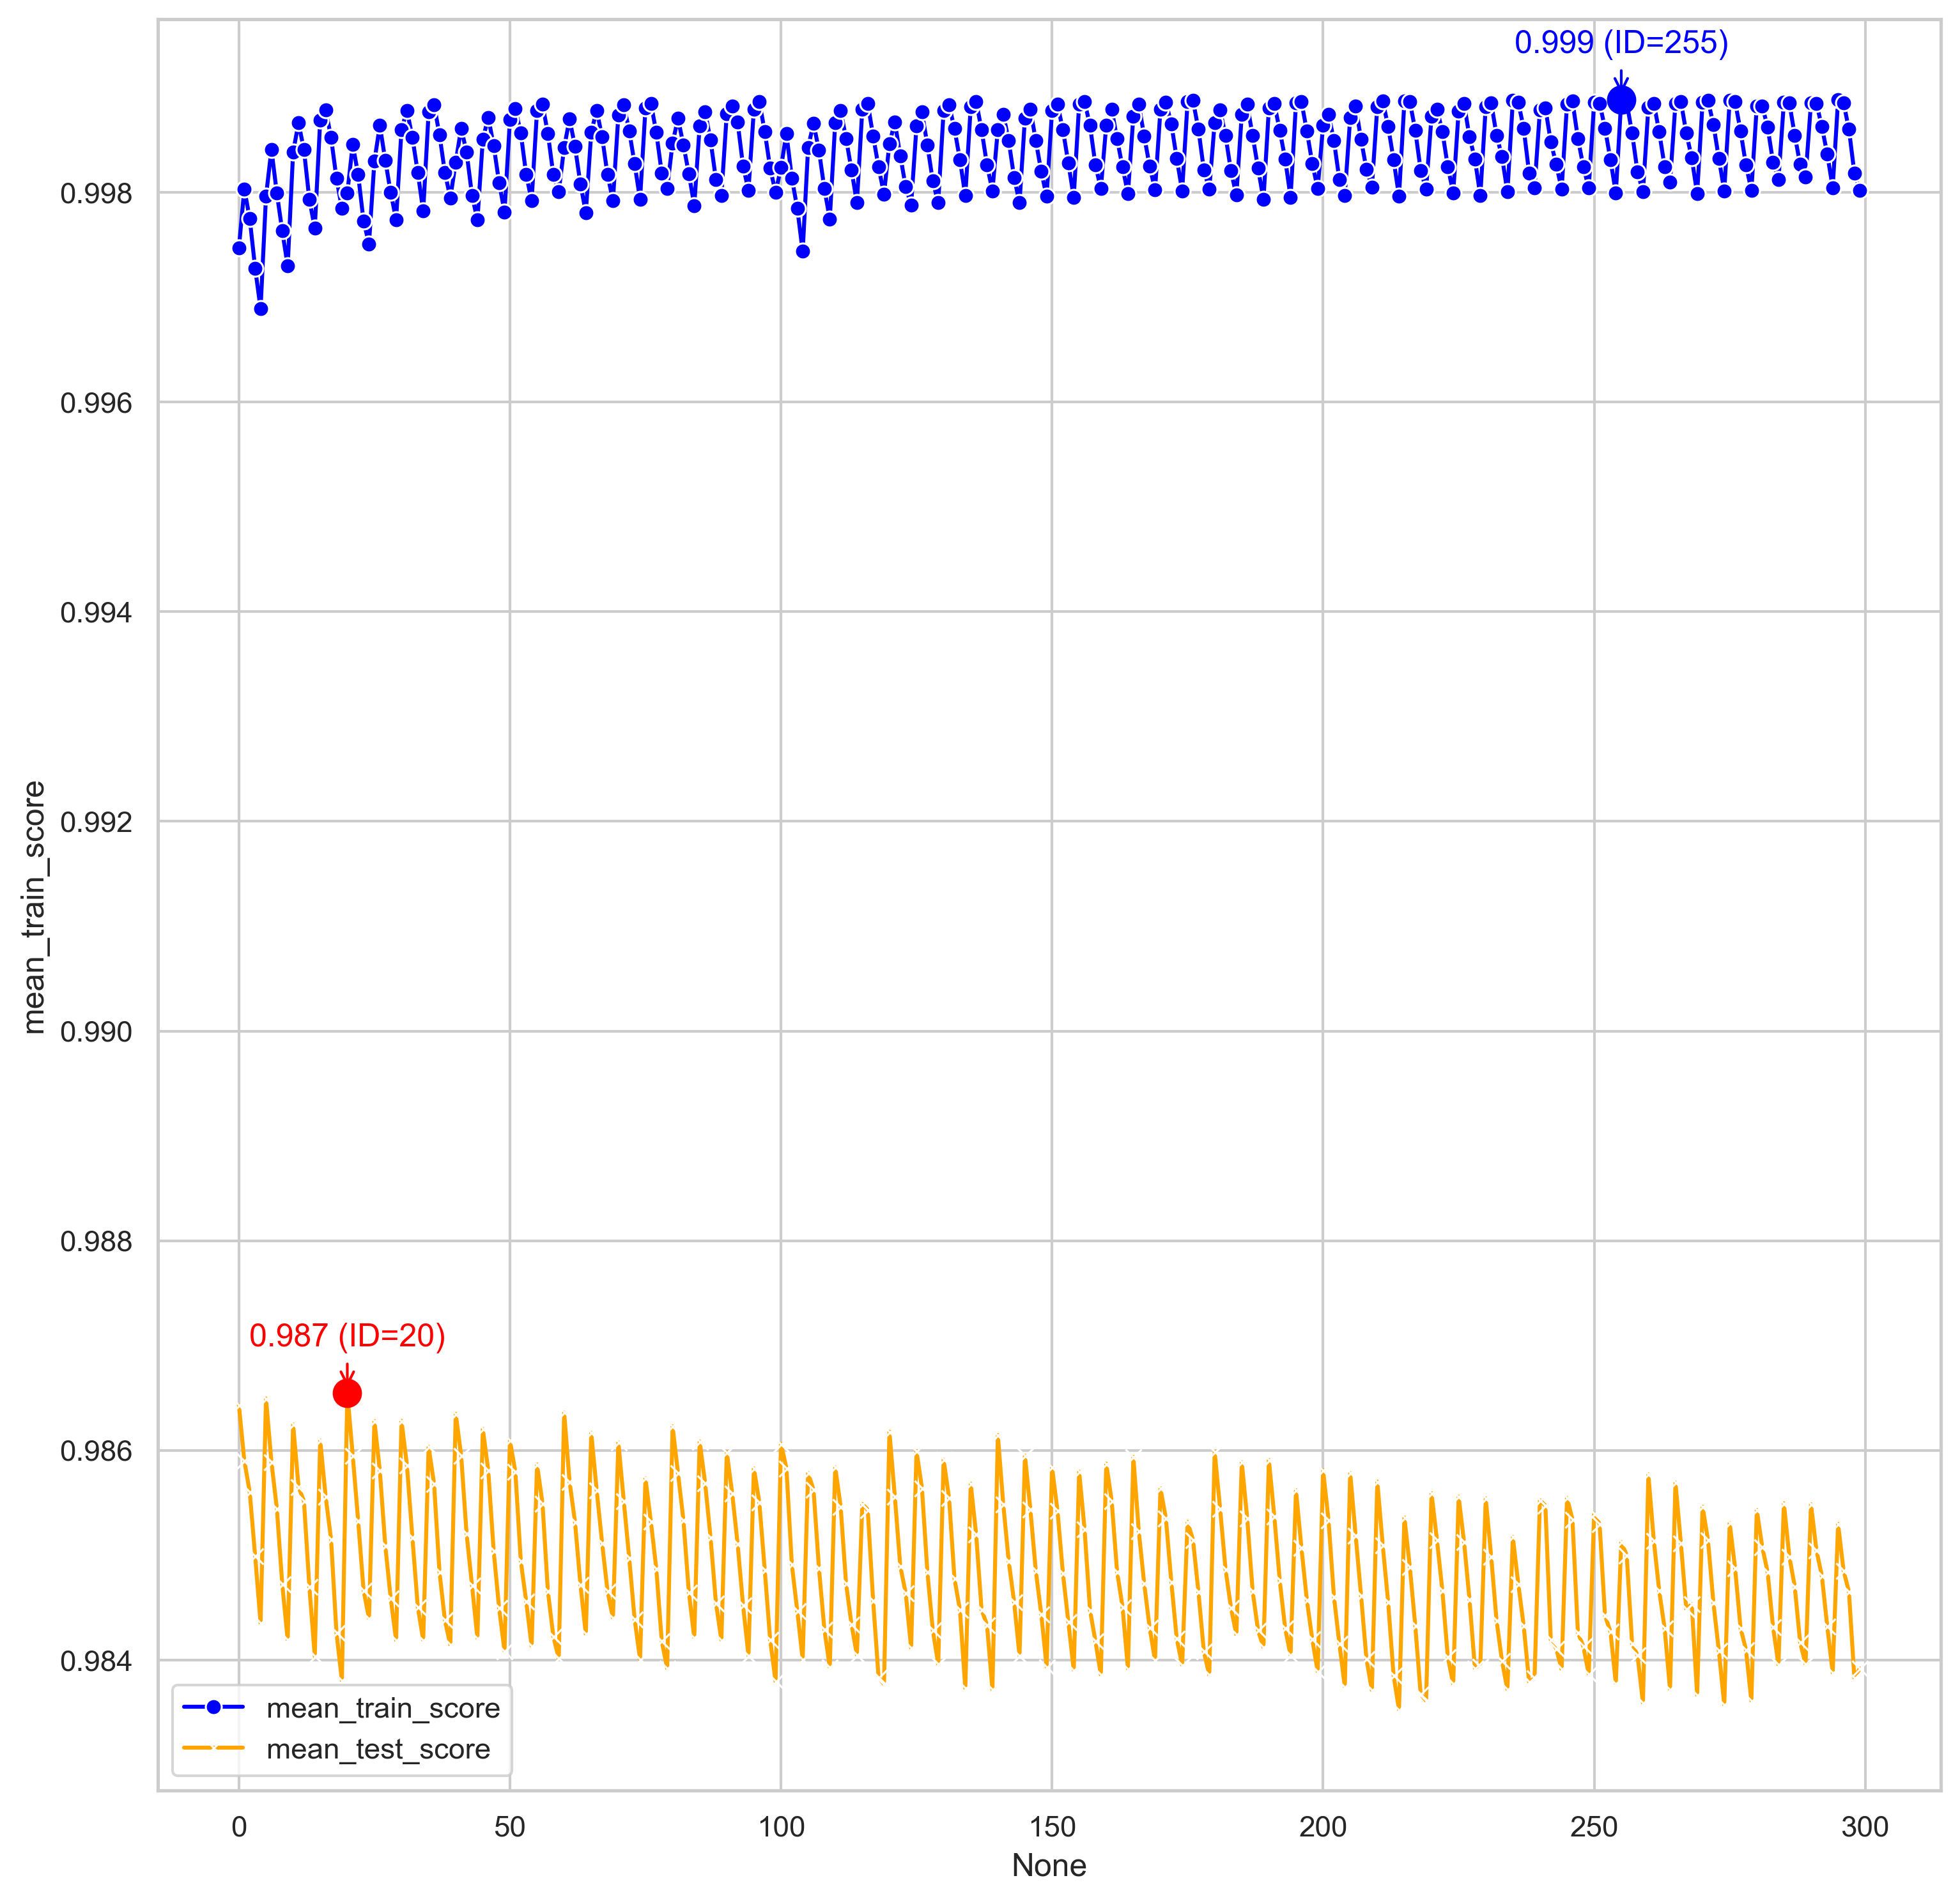

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
20       6.161820      0.110769         0.142415        0.001920           0   
5        8.720886      0.029892         0.225166        0.006255           0   
0        7.148292      0.677068         0.164598        0.006401           0   
60       7.857964      0.454982         0.178749        0.030472           0   
40       6.798474      0.050218         0.171346        0.009814           0   

   param_eta      param_eval_metric param_gamma param_grow_policy  \
20     0.075  [error, logloss, auc]         0.1         lossguide   
5      0.075  [error, logloss, auc]         0.1         lossguide   
0      0.075  [error, logloss, auc]         0.1         lossguide   
60     0.075  [error, logloss, auc]         0.1         lossguide   
40     0.075  [error, logloss, auc]         0.1         lossguide   

   param_lambda param_max_bin param_max_delta_step param_max_depth  \
20          1.0           512                    0               9   
5           1.0           512                    0               8   
0           1.0           512                    0               8   
60          1.0           512                    0              11   
40          1.0           512                    0              10   

   param_min_child_weight param_n_estimators  param_objective  \
20                    2.0                500  binary:logistic   
5                     2.0                600  binary:logistic   
0                     2.0                500  binary:logistic   
60                    2.0                500  binary:logistic   
40                    2.0                500  binary:logistic   

   param_sampling_method param_scale_pos_weight param_subsample  \
20               uniform                      1             0.6   
5                uniform                      1             0.6   
0                uniform                      1             0.6   
60               uniform                      1             0.6   
40               uniform                      1             0.6   

   param_tree_method                                             params  \
20              hist  {'alpha': 0, 'eta': 0.075, 'eval_metric': ['er...   
5               hist  {'alpha': 0, 'eta': 0.075, 'eval_metric': ['er...   
0               hist  {'alpha': 0, 'eta': 0.075, 'eval_metric': ['er...   
60              hist  {'alpha': 0, 'eta': 0.075, 'eval_metric': ['er...   
40              hist  {'alpha': 0, 'eta': 0.075, 'eval_metric': ['er...   

    split0_test_score  split1_test_score  split2_test_score  mean_test_score  \
20           0.986402           0.986785           0.986458         0.986548   
5            0.986370           0.986750           0.986364         0.986495   
0            0.986306           0.986591           0.986393         0.986430   
60           0.986312           0.986565           0.986208         0.986361   
40           0.986524           0.986561           0.985959         0.986348   

    std_test_score  rank_test_score  split0_train_score  split1_train_score  \
20        0.000169                1            0.997977            0.998024   
5         0.000180                2            0.997884            0.998009   
0         0.000119                3            0.997511            0.997479   
60        0.000150                4            0.998491            0.998398   
40        0.000275                5            0.998320            0.998305   

    split2_train_score  mean_train_score  std_train_score  
20            0.997978          0.997993         0.000022  
5             0.997993          0.997962         0.000055  
0             0.997417          0.997469         0.000039  
60            0.998398          0.998429         0.000044  
40            0.998242          0.998289         0.000034

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from xgboost import XGBClassifier

# XGBoost base model
xgb = XGBClassifier(random_state=7, n_jobs=-1)

# Grid of parameters to search
grid = {
    "objective": ["binary:logistic"],
    "tree_method": ["hist"],
    "sampling_method": ["uniform"],
    "eval_metric": [["error", "logloss", "auc"]],
    "grow_policy": ["lossguide"],
    "alpha": [0],
    "gamma": [0.1],
    "lambda": [1.0],
    "eta": [0.075, 0.1, 0.15],
    "max_delta_step": [0],
    "max_bin": [512],
    "min_child_weight": [2.0],
    "subsample": [0.6],
    "max_depth": np.arange(8, 13, 1),
    "n_estimators": [500, 600, 750, 1000],
    "scale_pos_weight": np.arange(1, 6, 1),
}

# Stratified K-Folds cross-validator
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)

# Grid Search
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=grid,
    cv=cv,
    scoring="f1",
    verbose=3,
    return_train_score=True,
    n_jobs=1,  # Cannot use all available CPUs - with XGBoost it is buggy
)

# Fit GridSearchCV to the scaled training data
grid_search.fit(X_train, y_train)

# Results of the grid search in a DataFrame
scores = pd.DataFrame(grid_search.cv_results_)

# Display tuning graph of grid search results
visualize_performance(scores)

# Set Pandas to display up to 50 columns of the DataFrame
pd.set_option("display.max_columns", 50)

# Print 5 best scores based on rank
scores.sort_values("rank_test_score").head()

# LightGBM


Fitting 3 folds for each of 432 candidates, totalling 1296 fits
[CV] boosting_type=gbdt, colsample_bytree=1, learning_rate=0.075, max_depth=11, min_child_samples=25, min_split_gain=0.01, n_estimators=1050, num_leaves=28, objective=binary, reg_lambda=0.45, scale_pos_weight=1.5, subsample=0.85, subsample_for_bin=200000, subsample_freq=1 
[CV]  boosting_type=gbdt, colsample_bytree=1, learning_rate=0.075, max_depth=11, min_child_samples=25, min_split_gain=0.01, n_estimators=1050, num_leaves=28, objective=binary, reg_lambda=0.45, scale_pos_weight=1.5, subsample=0.85, subsample_for_bin=200000, subsample_freq=1, score=(train=0.999, test=0.988), total=  37.1s
[CV] boosting_type=gbdt, colsample_bytree=1, learning_rate=0.075, max_depth=11, min_child_samples=25, min_split_gain=0.01, n_estimators=1050, num_leaves=30, objective=binary, reg_lambda=0.45, scale_pos_weight=1.7, subsample=0.85, subsample_for_bin=200000, subsample_freq=1 
[CV]  boosting_type=gbdt, colsample_bytree=1, learning_rate=0.075,

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed: 29.3min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed: 46.0min
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed: 66.1min
[Parallel(n_jobs=-1)]: Done 1296 out of 1296 | elapsed: 76.0min finished


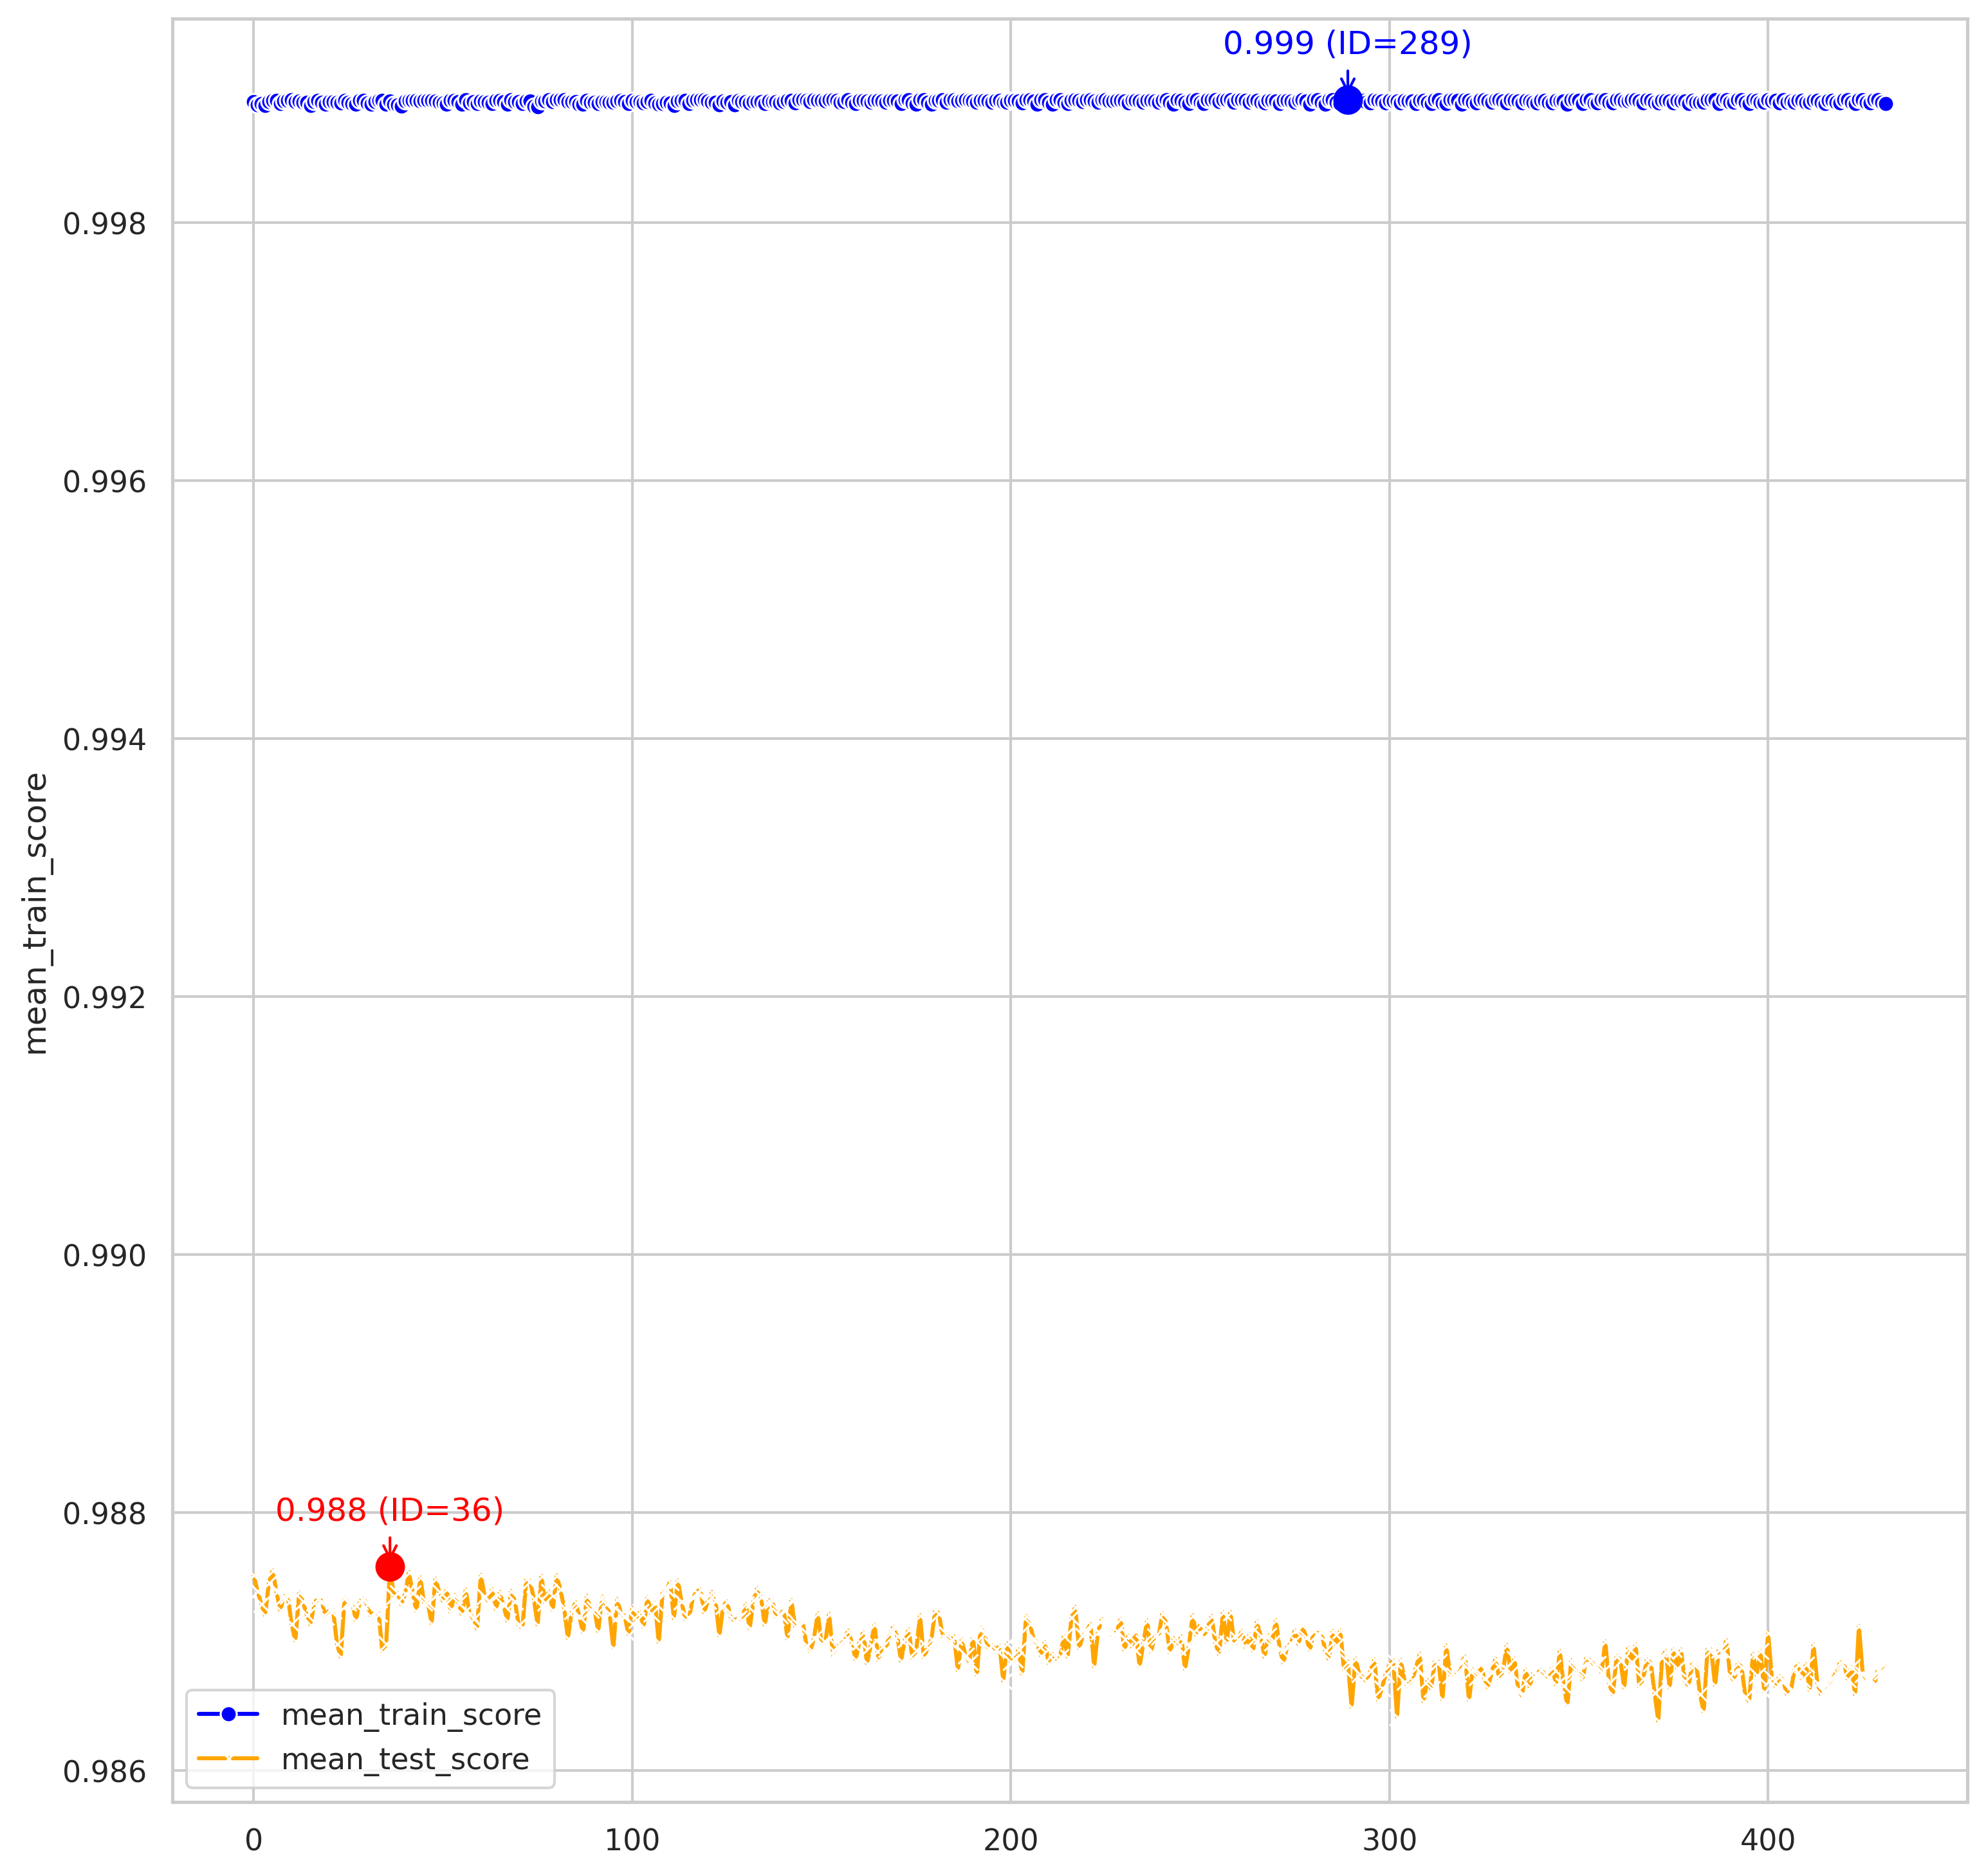

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
36      27.456037      0.748978         8.124233        0.184869   
5       30.284996      2.812131         8.850889        0.542144   
41      28.026686      0.140493         8.534332        0.207193   
60      32.452320      0.566947         8.485552        0.577747   
0       27.991562      0.156376         9.336670        0.465606   

   param_boosting_type param_colsample_bytree param_learning_rate  \
36                gbdt                      1               0.075   
5                 gbdt                      1               0.075   
41                gbdt                      1               0.075   
60                gbdt                      1               0.075   
0                 gbdt                      1               0.075   

   param_max_depth param_min_child_samples param_min_split_gain  \
36              12                      25                 0.01   
5               11                      25                 0.01   
41              12                      25                 0.01   
60              12                      25                 0.01   
0               11                      25                 0.01   

   param_n_estimators param_num_leaves param_objective param_reg_lambda  \
36               1050               28          binary             0.45   
5                1050               30          binary             0.45   
41               1050               30          binary             0.45   
60               1200               28          binary             0.45   
0                1050               28          binary             0.45   

   param_scale_pos_weight param_subsample param_subsample_for_bin  \
36                    1.4            0.85                  200000   
5                     1.5            0.85                  200000   
41                    1.5            0.85                  200000   
60                    1.4            0.85                  200000   
0                     1.4            0.85                  200000   

   param_subsample_freq                                             params  \
36                    1  {'boosting_type': 'gbdt', 'colsample_bytree': ...   
5                     1  {'boosting_type': 'gbdt', 'colsample_bytree': ...   
41                    1  {'boosting_type': 'gbdt', 'colsample_bytree': ...   
60                    1  {'boosting_type': 'gbdt', 'colsample_bytree': ...   
0                     1  {'boosting_type': 'gbdt', 'colsample_bytree': ...   

    split0_test_score  split1_test_score  split2_test_score  mean_test_score  \
36           0.988235           0.987373           0.987129         0.987579   
5            0.988022           0.987684           0.986947         0.987551   
41           0.988081           0.987588           0.986947         0.987539   
60           0.988017           0.987465           0.987070         0.987517   
0            0.988204           0.987456           0.986883         0.987514   

    std_test_score  rank_test_score  split0_train_score  split1_train_score  \
36        0.000475                1            0.998863            0.998894   
5         0.000449                2            0.998863            0.998894   
41        0.000464                3            0.998863            0.998894   
60        0.000389                4            0.998863            0.998894   
0         0.000541                5            0.998847            0.998894   

    split2_train_score  mean_train_score  std_train_score  
36            0.999081          0.998946         0.000096  
5             0.999081          0.998946         0.000096  
41            0.999081          0.998946         0.000096  
60            0.999081          0.998946         0.000096  
0             0.999081          0.998941         0.000101


[CV] boosting_type=gbdt, colsample_bytree=1, learning_rate=0.15, max_depth=13, min_child_samples=25, min_split_gain=0.01, n_estimators=1150, num_leaves=28, objective=binary, reg_lambda=0.45, scale_pos_weight=1.5, subsample=0.85, subsample_for_bin=200000, subsample_freq=1 
[CV]  boosting_type=gbdt, colsample_bytree=1, learning_rate=0.15, max_depth=13, min_child_samples=25, min_split_gain=0.01, n_estimators=1150, num_leaves=28, objective=binary, reg_lambda=0.45, scale_pos_weight=1.5, subsample=0.85, subsample_for_bin=200000, subsample_freq=1, score=(train=0.999, test=0.987), total=  36.9s
[CV] boosting_type=gbdt, colsample_bytree=1, learning_rate=0.15, max_depth=13, min_child_samples=25, min_split_gain=0.01, n_estimators=1150, num_leaves=30, objective=binary, reg_lambda=0.45, scale_pos_weight=1.6, subsample=0.85, subsample_for_bin=200000, subsample_freq=1 
[CV]  boosting_type=gbdt, colsample_bytree=1, learning_rate=0.15, max_depth=13, min_child_samples=25, min_split_gain=0.01, n_estimat

In [7]:
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# LightGBM base model
lgbm = LGBMClassifier(n_jobs=-1, random_state=7)

# Grid of parameters to search
grid = {
    "objective": ["binary"],  # binary classification
    "boosting_type": ["gbdt"],  # Gradient Boosting Decision Tree
    "min_child_samples": [25],
    "colsample_bytree": [1],
    "reg_lambda": [0.45],
    "subsample": [0.85],
    "subsample_freq": [1],
    "subsample_for_bin": [200000],
    "min_split_gain": [0.01],
    "n_estimators": [1050, 1150, 1200],
    "max_depth": [11, 12, 13, 14],
    "num_leaves": [28, 30, 32],
    "learning_rate": [0.075, 0.1, 0.15],
    "scale_pos_weight": [1.4, 1.5, 1.6, 1.7],
}

# Stratified K-Folds cross-validator
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)

# Grid Search
grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=grid,
    cv=cv,
    scoring="f1",
    verbose=3,
    return_train_score=True,
    n_jobs=-1,  # Use all available CPUs
)

# Fit GridSearchCV to the scaled training data
grid_search.fit(X_train, y_train)

# Results of the grid search in a DataFrame
scores = pd.DataFrame(grid_search.cv_results_)

# Display tuning graph of grid search results
visualize_performance(scores)

# Set Pandas to display up to 50 columns of the DataFrame
pd.set_option("display.max_columns", 50)

# Print 5 best scores based on rank
scores.sort_values("rank_test_score").head()

# Neural Network


In [7]:
import random

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Set the number of threads for inter-op parallelism
tf.config.threading.set_inter_op_parallelism_threads(0)

# Set the number of threads for intra-op parallelism
tf.config.threading.set_intra_op_parallelism_threads(0)

# Set seed on Tensorflow, Keras, Numpy
seed = 7
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
tf.keras.utils.set_random_seed(seed)
tf.config.experimental.enable_op_determinism()

# Data preparation
min_rows = min(len(dga), len(benign))

dga_truncated = dga[:min_rows]

benign_truncated = benign[:min_rows]

data = pa.concat_tables([dga_truncated, benign_truncated])

nn_df = data.to_pandas()

# Train-Test split and normalization
class_map = {"benign": 0, "dga": 1}

labels = nn_df["label"].apply(lambda x: class_map[x])  # y vector
features = nn_df.drop("label", axis=1).copy()  # X matrix

# Normalise the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(features)
features = pd.DataFrame(scaled_data, columns=features.columns)

# Train Test split
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.3, random_state=42, shuffle=True, stratify=labels
)

# Model definition
nn = Sequential()
nn.add(Dense(64, activation="relu", input_shape=(48,)))
nn.add(Dropout(0.15))
nn.add(Dense(64, activation="relu"))
nn.add(Dropout(0.15))
nn.add(Dense(64, activation="relu"))
nn.add(Dropout(0.15))
nn.add(Dense(64, activation="relu"))
nn.add(Dropout(0.15))
nn.add(Dense(32, activation="relu"))
nn.add(Dropout(0.1))
nn.add(Dense(1, activation="sigmoid"))

nn.summary()

nn.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=0.001),
    metrics=[Precision(), Recall(), AUC()],
)

# Shuffle
nn_x_train, nn_y_train = shuffle(X_train, y_train, random_state=seed)

# Early stopping
early_stopping_monitor = EarlyStopping(
    monitor="val_loss", patience=8, restore_best_weights=True
)

# Create Neural Network model with specified parameters
nn.fit(
    nn_x_train, nn_y_train, batch_size=127, epochs=290, validation_split=0.1
)  # , callbacks=[early_stopping_monitor])

# Prediction
y_pred_prob = nn.predict(X_test)

y_pred = np.round(y_pred_prob).astype(int)

# Compute metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_sc = roc_auc_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
fpr = fp / (fp + tn)

print("fpr", fpr)

# Store metrics in dataframe
results_df = pd.DataFrame(
    {
        "Accuracy": [accuracy],
        "Precision": [precision],
        "Recall": [recall],
        "F1": [f1],
        "AUC": [auc_sc],
        "FPR": [fpr],
    }
)

print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
print(cm)

# Print the results in a dataframe - well-formatted table
results_df

c:\Users\matej\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,729 (69.25 KB)

 Trainable params: 17,729 (69.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/290
2278/2278 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - auc: 0.9887 - loss: 0.1115 - precision: 0.9735 - recall: 0.9389 - val_auc: 0.9987 - val_loss: 0.0388 - val_precision: 0.9925 - val_recall: 0.9798
Epoch 2/290
2278/2278 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - auc: 0.9980 - loss: 0.0457 - precision: 0.9881 - recall: 0.9813 - val_auc: 0.9987 - val_loss: 0.0365 - val_precision: 0.9921 - val_recall: 0.9821
Epoch 3/290
2278/2278 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - auc: 0.9981 - loss: 0.0429 - precision: 0.9896 - recall: 0.9817 - val_auc: 0.9990 - val_loss: 0.0366 - val_precision: 0.9926 - val_recall: 0.9828
Epoch 4/290
2278/2278 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - auc: 0.9983 - loss: 0.0410 - precision: 0.9894 - recall: 0.9825 - val_auc: 0.9989 - val_loss: 0.0355 - val_precision: 0.9926 - val_recall: 0.9824
Epoch 5/290
2278/2278 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - auc: 0.9984 - loss: 0.0401 - precision: 0.9899 - recall: 0.9828 - val_auc: 0.9990 - val_loss: 0.0349 - val_precision: 0.9917 - val

Accuracy  Precision    Recall        F1       AUC       FPR
0  0.991158   0.992445  0.989851  0.991146  0.991158  0.007535